In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy import displacy
import matplotlib.pyplot as plt

C:\Users\86138\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\86138\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\86138\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\86138\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passi

In [2]:
NER = spacy.load("en_core_web_sm")

In [3]:
data_peru = pd.read_csv('D:\\Peru Data_1.csv', encoding='ANSI')
data_peru_s2 = pd.read_csv('D:\\Peru Data_2.csv', encoding = 'ANSI')
data_peru_s3 = pd.read_csv('D:\\Peru Data_3.csv', encoding = 'ANSI')
data_peru_s4 = pd.read_csv('D:\\Peru Data_4.csv', encoding = 'ANSI')
data_peru_s5 = pd.read_csv('D:\\Peru Data_5.csv', encoding = 'ANSI')

In [4]:
data_peru.dropna(axis = 1, how='any', inplace=True)

In [1]:
# Named Entity Recognition
'''
Spacy is one of the most useful models in Names Entity Recognition. 
Based on the text, it will return the label of each word, i.e. is this a name of organization or person.
If the label is ORG, it shows the company, agency and institution
If the label is GPE, it shows the city, country or state
'''
def ner(df, column_number):    # df is the dataframe that needs to be processed; column_number is the number of entites that display
    
    label_org = [] # label for the organization, agency and institution
    word_text_org = [] # corresponding words
    
    label_gpe = []   # label for the country, state and city
    word_text_gpe = []   # corresponding words
    
    # combine every text into a string
    text = ""
    for i in range(0, len(df)):
        text = text + str(df.iloc[:,column_number][i]) + " "
    
    # conduct the analysis
    NER = spacy.load("en_core_web_sm")
    text1 = NER(text)
    
    for word in text1.ents:
        if(word.label_ == 'ORG'):
            word_text_org.append(word.text)
        elif(word.label_ == 'GPE'):
            word_text_gpe.append(word.text)
        else:
            continue
    # calculate the frequency of the word in 'organization' list
    d_org = {}
    for x in word_text_org:
        if not x in d_org:
            d_org[x] = 1
        else:
            d_org[x] = d_org[x] + 1
            
    # sort the word in descending order
    item_org = sorted(d_org.items(), key = lambda x: x[1], reverse = True)
    
    d_gpe_1 = {}
    for x in word_text_gpe:
        if not x in d_gpe_1:
            d_gpe_1[x] = 1
        else:
            d_gpe_1[x] = d_gpe_1[x] + 1
            
    item_gpe = sorted(d_gpe_1.items(), key = lambda x: x[1], reverse = True)
    
    return(item_org, item_gpe)


def merge_dict(x, y):
    for k, v in x.items():
        if k in y.keys():
            y[k] = y[k] + v
        else:
            y[k] = v
    return y

# Merge frequencies of words that differ only by case
def capital_to_lower_combine(dict_info):   # dictionary which includes both the upper case and lower case words
    value = []
    new_lower = []
    original_key = []

    for i, j in dict_info.items():
        original_key.append(i)
        value.append(j)
        new_lower.append(i.lower())
        
    # translate the dictionary into dataframe
    test = pd.DataFrame({'Organization':new_lower,'Value':value})
    # count the frequency based on the lower case
    df_count = (test.groupby('Organization').sum())
    df_count = df_count.reset_index(drop=False)
    df = df_count.sort_values(by = "Value" , ascending = False)
    df = df.reset_index(drop=True)
    
    df['dict_reflection'] = "a"
    # Replace the current lowercase word with the original word
    for i in range(len(df)):
        for j in range(0, len(original_key)):
            if(df.iloc[i, 0] == new_lower[j]):
                df.iloc[i, 2] = original_key[j]
                
    df.drop(columns='Organization', inplace = True)
                
    return df

# horizonal bar chart plot
def draw_from_dict(dicdata, RANGE, h = 0):
    fig = plt.figure(figsize=(20, 10))
    
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    
    x = []
    y = []
    
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
        
    if h == 0:
        plt.bar(x[0:RANGE], y[0:RANGE])
        fig.autofmt_xdate(rotation = 90)
        plt.savefig('Peru.svg', format = 'svg')
        plt.show() 
        return 
    
    elif h == 1:
        plt.barh(x[0:RANGE], y[0:RANGE])
        fig.autofmt_xdate(rotation = 0)
        plt.savefig('Peru.svg', format = 'svg')
        plt.show()
        return
    
    else:
        return "Error in input value!"

In [57]:
def OvertimeAnalysis(df):

    compound = []

    sentences = list(df['doc_content'].values)
    for sentence in sentences:
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(sentence)
        compound.append(ss['compound'])
        
    # use the avergae yearly sentiment score
    df.loc[:,'sentiment'] = compound
    df2 = df.groupby('doc_year')['sentiment'].mean()
    
    df_date_sentiment = df2.to_frame()
    df_date_sentiment = df_date_sentiment.reset_index()
    
    plt.style.use('ggplot')

    fig = plt.figure(figsize=(20, 15))

    plt.plot(df_date_sentiment['doc_year'],
             df_date_sentiment['sentiment'],
             linestyle = '-',
             linewidth = 2,
             color = 'steelblue',
             marker = 'o',
             markersize = 6,
             markeredgecolor='black',
             markerfacecolor='brown')

    plt.title('Sentiment Over Time')
    plt.xlabel('Year')
    plt.ylabel('Compound Sentiment')
    plt.ylim(-1, 1)

    plt.tick_params(top = 'off', right = 'off')

    fig.autofmt_xdate(rotation = 90)

    plt.savefig('Peru-analysis.svg', format = 'svg')

    plt.show()
    
    return

In [6]:
def OvertimeAnalysis_doc(df):

    compound = []

    sentences = list(df['doc_content'].values)
    for sentence in sentences:
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(sentence)
        compound.append(ss['compound'])
    
    df.loc[:,'sentiment'] = compound
    df2 = df.groupby('doc_year')['sentiment'].mean()
    
    df_date_sentiment = df2.to_frame()
    df_date_sentiment = df_date_sentiment.reset_index()
    return(df_date_sentiment)

In [6]:
item_org_1, item_gpe_1 = ner(data_peru[0:100], 9)

In [7]:
item_org_2, item_gpe_2 = ner(data_peru_s2, 9)

In [8]:
item_org_3, item_gpe_3 = ner(data_peru_s3, 9)

In [9]:
item_org_4, item_gpe_4 = ner(data_peru_s4, 9)

In [10]:
item_org_5, item_gpe_5 = ner(data_peru_s5, 9)

In [11]:
dict_item_org_1 = dict(item_org_1)
dict_item_org_2 = dict(item_org_2)
dict_item_org_3 = dict(item_org_3)
dict_item_org_4 = dict(item_org_4)
dict_item_org_5 = dict(item_org_5)

In [12]:
item_org_12 = merge_dict(dict_item_org_1, dict_item_org_2)
item_org_34 = merge_dict(dict_item_org_3, dict_item_org_4)
item_org_1234 = merge_dict(item_org_12, item_org_34)
item_org_12345 = merge_dict(item_org_1234, dict_item_org_5)

In [13]:
item_org_12345

{'the State Party': 1628,
 'Committee': 2012,
 'the World Heritage Committee': 732,
 'the World Heritage Centre': 715,
 'the Ministry of Culture': 152,
 'Bureau': 830,
 'World Heritage': 666,
 'the List of World Heritage': 344,
 'the Advisory Bodies': 267,
 'The State Party': 147,
 'The World Heritage Committee': 273,
 'UNESCO': 319,
 'the Qhapaq Nan': 46,
 'USD Missions': 71,
 'DDC': 29,
 'ICCROM': 74,
 'PECACH': 38,
 'UGM': 37,
 'The World Heritage Centre': 80,
 'the World Heritage Fund': 172,
 'Decision': 25,
 'the Qhapag Nan': 18,
 'World Heritage Centre': 47,
 'State': 53,
 'Cusco': 66,
 'HIA': 54,
 'Secretariat': 155,
 'the Operational Guidelines': 103,
 'Cuzco (Approved': 12,
 'Chav铆n': 18,
 'Qhapagq Nan': 13,
 'the Bureau of the World Heritage Committee': 53,
 'the Historic Sanctuary': 36,
 'Identity': 23,
 'IUCN': 513,
 'World Heritage Sites': 14,
 'Observer': 26,
 'INC': 76,
 'State Party': 24,
 'the International Support Panel': 16,
 'the Historic Centre of Lima': 26,
 'Acti

In [14]:
df = capital_to_lower_combine(item_org_12345)

In [16]:
df.to_csv('test.csv', encoding='UTF-8_sig')

In [115]:
data_peru_final = pd.read_csv('C:\\Users\\86138\\Desktop\\AJ_peru.csv')
data_peru_final.head()

,Value,Organization
0,513,IUCN
1,165,THE MINISTRY OF CULTURE
2,86,Aguas Calientes
3,76,INC
4,76,Inca


In [116]:
dict_peru = dict(zip(data_peru_final['Organization'],data_peru_final['Value']))
dict_peru

{'IUCN': 513,
 'THE MINISTRY OF CULTURE': 165,
 'Aguas Calientes': 86,
 'INC': 76,
 'Inca': 76,
 'ICCROM': 74,
 'Cusco': 66,
 'Icomos': 63,
 'Arequipa': 48,
 'Pampas de Jumana': 48,
 'The Qhapaq Nan': 47,
 'The World Bank': 40,
 'PECACH': 38,
 'INRENA': 37,
 'The Historic Sanctuary': 37,
 'Historical Centre of the City of Arequipa': 31,
 'DDC': 29,
 'Okapi Wildlife Reserve': 28,
 'Seville': 28,
 'The Historic Centre of Lima': 28,
 'Garamba National Park': 27,
 'Durban': 25,
 'the National Institute for Culture (INC)': 25,
 'Santa Laura Saltpeter Works': 23,
 'Vilnius': 23,
 'UNDP': 23,
 'The National Institute for Natural Resources': 23,
 'El Vizcaino': 22,
 'Paraguay': 21,
 'Casas Grandes': 21,
 'The Asian Development Bank': 21,
 'EIA': 21,
 'Virunga National Park': 20,
 'The Peruvian Government': 20,
 'Chiyoda-ku TOKYO': 20,
 'Selous Game Reserve': 19,
 'Kahuzi-Biega National Park': 19,
 'the National Institute of Culture': 19,
 'The International Support Panel': 18,
 'the Qhapag Nan

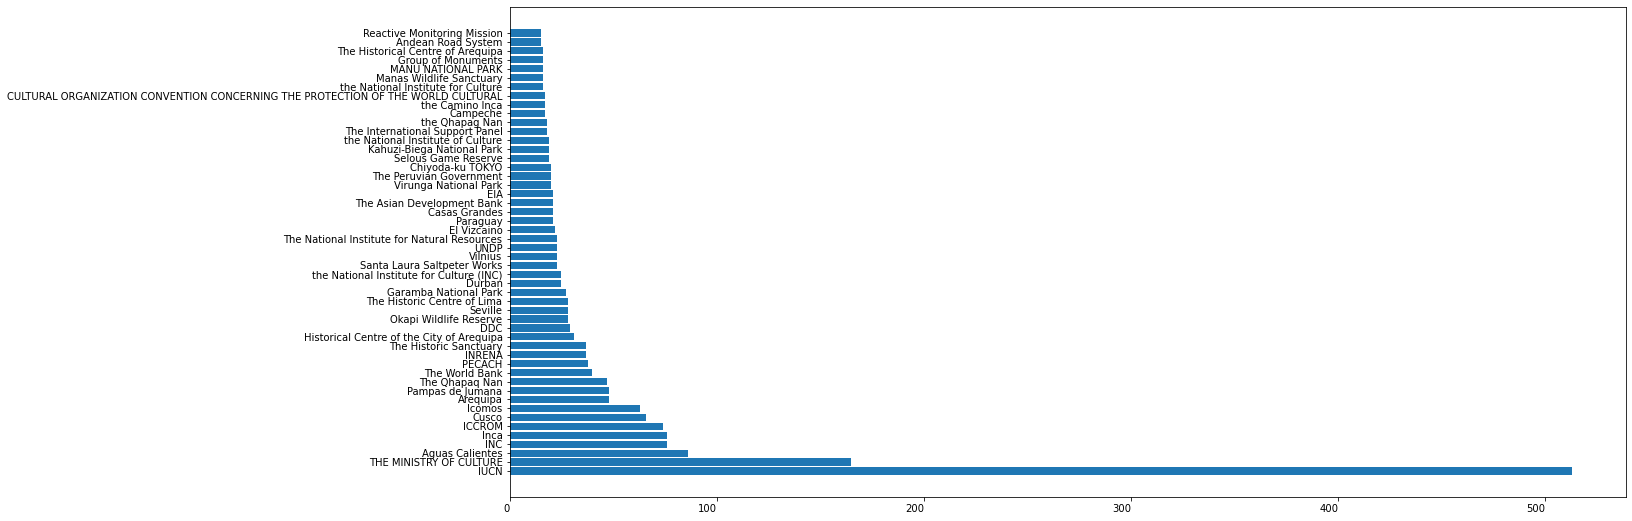

In [117]:
draw_from_dict(dict_peru, 50, h = 1)

# Taj Mahal Analysis - Main Topic and Themes

In [3]:
data_india = pd.read_csv("D:\\India Data.csv", encoding = 'ANSI', low_memory=False)

In [4]:
data_india.head()

,country_name,country_link,site_name,site_link,coordinates,doc_title,doc_link,doc_year,doc_type,doc_content,...,Unnamed: 2992,Unnamed: 2993,Unnamed: 2994,Unnamed: 2995,Unnamed: 2996,Unnamed: 2997,Unnamed: 2998,Unnamed: 2999,Unnamed: 3000,Unnamed: 3001
0,India,https://whc.unesco.org/en/statesparties/in,Chhatrapati Shivaji Terminus (formerly Victori...,https://whc.unesco.org/en/list/945,N18 56 24.44 E72 50 10.33,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/154660,2004,ABevaluation,Chhatrapati Shivaji Terminus (India) No 945 re...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,India,https://whc.unesco.org/en/statesparties/in,Manas Wildlife Sanctuary,https://whc.unesco.org/en/list/338,N26 43 30 E91 1 50,Advisory Body Evaluation (IUCN),https://whc.unesco.org/document/153224,1985,ABevaluation,"a . 1 "" 1 A a i a q 7 1 i 1 4 4 鈥?f { 鈥?NOMINA...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,India,https://whc.unesco.org/en/statesparties/in,Great Living Chola Temples,https://whc.unesco.org/en/list/250,N10 46 59 E79 7 57,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/153042,2004,ABevaluation,Chola Temples (India) No 250 bis 1. BASIC DATA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,India,https://whc.unesco.org/en/statesparties/in,Great Living Chola Temples,https://whc.unesco.org/en/list/250,N10 46 59 E79 7 57,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/153044,1987,ABevaluation,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,India,https://whc.unesco.org/en/statesparties/in,Ellora Caves,https://whc.unesco.org/en/list/243,N20 1 35.004 E75 10 45.012,Advisory Body Evaluation (ICOMOS) / 脡valuation...,https://whc.unesco.org/document/153028,1983,ABevaluation,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data_india.dropna(axis = 1, how='any', inplace=True)

In [17]:
data_taj_mahal = data_india[data_india['site_name'].str.contains('Taj Mahal')]
data_taj_mahal = data_taj_mahal.reset_index(drop = True)
data_taj_mahal.head(1)

,country_name,country_link,site_name,site_link,coordinates,doc_title,doc_link,doc_year,doc_type,doc_content
0,India,https://whc.unesco.org/en/statesparties/in,Taj Mahal,https://whc.unesco.org/en/list/252,N27 10 27.012 E78 2 31.992,Advisory Body Evaluation (ICOMOS) / 脡valuation...,https://whc.unesco.org/document/153049,1983,ABevaluation,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...


In [20]:
item_org_TM, item_gpe_TM = ner(data_taj_mahal, 9)

In [24]:
df = capital_to_lower_combine(dict(item_org_TM))

In [25]:
df.to_csv('India_TM.csv', encoding='UTF-8_sig')

In [27]:
df_TM = pd.read_csv('./India_TM.csv')
df_TM.head(1)

,Value,Organization
0,11,IUCN


In [28]:
dict_TM = dict(zip(df_TM['Organization'],df_TM['Value']))
dict_TM

{'IUCN': 11,
 'Fatehpur Sikri': 8,
 'ASI': 8,
 'the Advisory Bodies': 8,
 'CISF': 7,
 'Secretariat': 6,
 'ICOMOS': 5,
 'The Archaeological Survey of India': 3,
 'Yamuna': 3,
 'Agra': 3,
 'Mausoleum': 2,
 'the "Taj Heritage Corridor Project': 2,
 'Talamanca Range-La Amistad Reserve': 2,
 'the Supreme Court': 2,
 'Kongoli': 2,
 'Florence': 2,
 'Inca': 2,
 'Gorowi': 2,
 'WHF': 2,
 'Baroque Churches': 2,
 'Mogul': 2,
 'Sao Miguel': 2,
 'Queen Arjumand Banu Begam': 2,
 'Rila': 2,
 'Prambanan Temple Compounds': 2,
 'Caiano': 2,
 'Agra Fort': 2,
 'the Central Industrial Security Force': 1,
 'the Central Office of Historic Monuments Riksantikvaren': 1,
 'Rhodia Chemicals': 1,
 'the Church of St. Elizabeth of Marburg': 1,
 'the Central Power Water Research Centre': 1,
 'the Cultural Environment of Florence': 1,
 'the Directorate Office': 1,
 'the Djoudj National Bird Sanctuary': 1,
 'the Asian Development Bank': 1,
 'Srebarna Nature Reserve': 1,
 'Royal Hill': 1,
 'the Antiquities Department': 

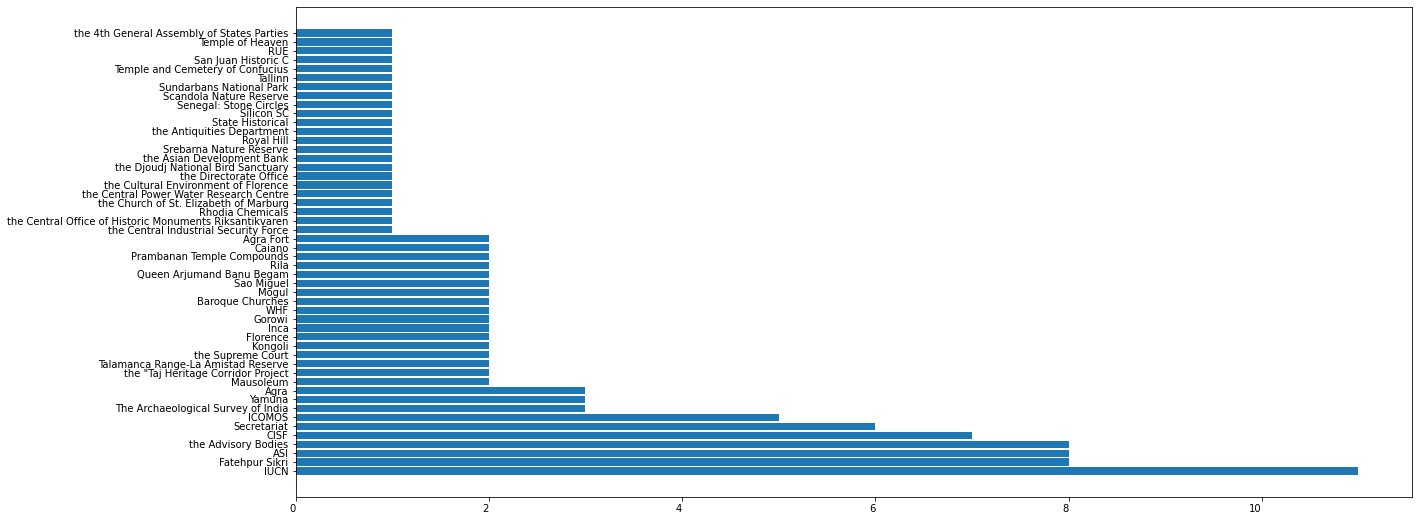

In [29]:
draw_from_dict(dict_TM, 50, h = 1)

In [34]:
data_TM_for_analysis = data_taj_mahal.iloc[:, [2,5,7,9]]
data_TM_for_analysis.head(5)

,site_name,doc_title,doc_year,doc_content
0,Taj Mahal,Advisory Body Evaluation (ICOMOS) / 脡valuation...,1983,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...
1,Taj Mahal,37COM 7B.103 - Omnibus Decision,2013,"World Heritage Committee, 1. Having examined D..."
2,Taj Mahal,36COM 8E - Adoption of retrospective Statement...,2012,"The World Heritage Committee, 1. Having examin..."
3,Taj Mahal,"27COM 7B.105 - Agra Fort, Taj Mahal, Fatehpur ...",2003,"The World Heritage Committee,1. Expresses grav..."
4,Taj Mahal,"28COM 15B.58 - Taj Mahal, Agra Fort and Fatehp...",2004,"The World Heritage Committee, Takes note of th..."


C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


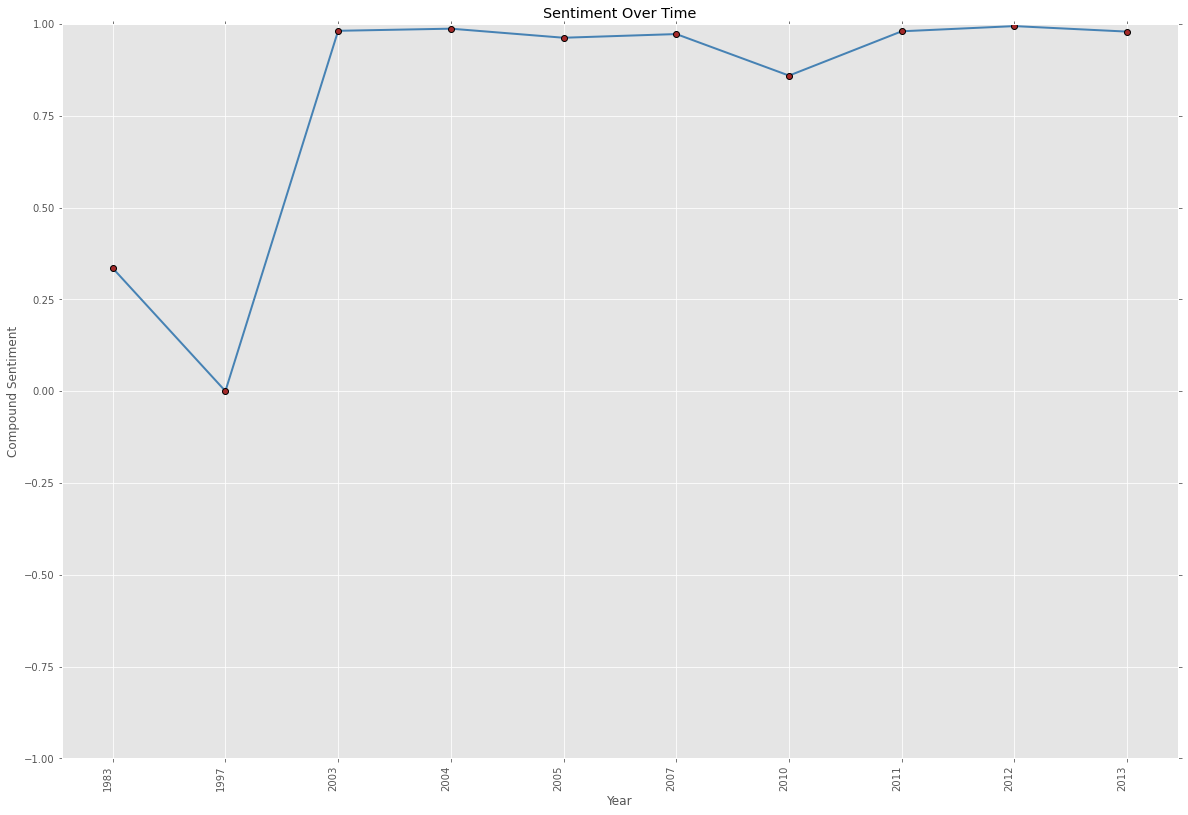

In [58]:
OvertimeAnalysis(data_TM_for_analysis)

# qutb minar Analysis - Sentiment and Themes

In [64]:
data_QM = data_india[data_india['site_name'].str.contains('Qutb Minar and its Monuments, Delhi')]
data_QM = data_QM.reset_index(drop = True)
data_QM.head(1)

,country_name,country_link,site_name,site_link,coordinates,doc_title,doc_link,doc_year,doc_type,doc_content,...,Unnamed: 2992,Unnamed: 2993,Unnamed: 2994,Unnamed: 2995,Unnamed: 2996,Unnamed: 2997,Unnamed: 2998,Unnamed: 2999,Unnamed: 3000,Unnamed: 3001
0,India,https://whc.unesco.org/en/statesparties/in,"Qutb Minar and its Monuments, Delhi",https://whc.unesco.org/en/list/233,N28 31 32.988 E77 11 7.008,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/153020,1993,ABevaluation,WORLD HERITAGE LIST The Qutb Minar No 233 Iden...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
item_org_QM, item_gpe_QM = ner(data_QM, 9)

In [66]:
df_QM = capital_to_lower_combine(dict(item_org_QM))

In [67]:
df_QM.to_csv('India_QM.csv', encoding='UTF-8_sig')

In [69]:
df_QM_2 = pd.read_csv('./India_QM.csv')
df_QM_2.head()

,Value,Organization
0,7,IUCN
1,5,The Archaeological Survey of India
2,5,ICCROM
3,4,UNDP
4,4,NAL


In [70]:
dict_QM = dict(zip(df_QM_2['Organization'],df_QM_2['Value']))
dict_QM

{'IUCN': 7,
 'The Archaeological Survey of India': 5,
 'ICCROM': 5,
 'UNDP': 4,
 'NAL': 4,
 'RAPPORTEUR': 3,
 'Badran': 3,
 'the International Council on Monuments and Sites (ICOMOS': 2,
 'the International Centre for the Study of the Preservation': 2,
 'Alai-Darwaza': 2,
 'Amendment Rules': 2,
 'Paraguay': 2,
 'the World Bank': 2,
 'the World Conservation Union': 2,
 'Education of Colombia': 2,
 'the Ancient Monument and Archaeological Site': 2,
 "Qutbu'd-Din Aibak": 2,
 'Archaeological Survey of India': 2,
 'COLCULTURA': 2,
 'the Delhi Development Act': 1,
 'the Delegate of Colombia': 1,
 'the Jesuit Missions': 1,
 'the Cultural Property': 1,
 'The Indian Oil Corporation': 1,
 'the Historic Centre of La Havana': 1,
 'the Global Environmental Forum': 1,
 'The Delegate of Italy': 1,
 'The Delhi Municipal Corporation Act': 1,
 'the General Assembly': 1,
 'The Archaeological Survey of Ind': 1,
 'the Environment (Protection) Act': 1,
 'the Delegates of France': 1,
 'the Monastery of Horez

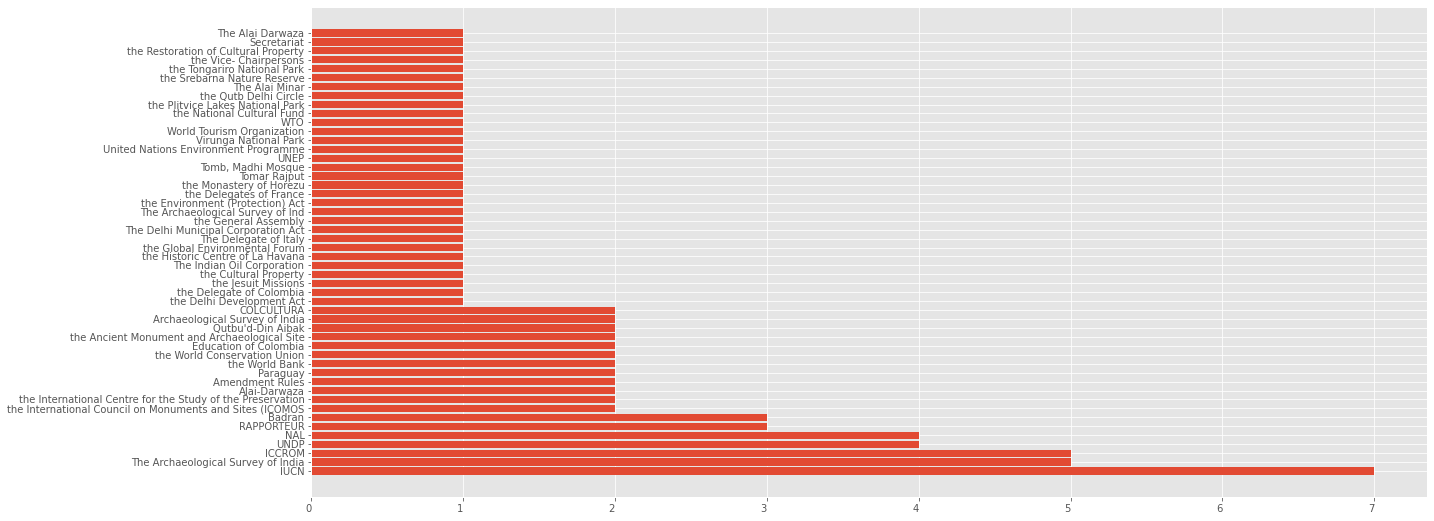

In [71]:
draw_from_dict(dict_QM, 50, h = 1)

In [72]:
data_QM_for_analysis = data_QM.iloc[:, [2,5,7,9]]
data_QM_for_analysis.head(5)

,site_name,doc_title,doc_year,doc_content
0,"Qutb Minar and its Monuments, Delhi",Advisory Body Evaluation (ICOMOS),1993,WORLD HERITAGE LIST The Qutb Minar No 233 Iden...
1,"Qutb Minar and its Monuments, Delhi",Report of the 17th Session of the Committee,1993,"WH Committee, Report of the 17th Session, Cart..."
2,"Qutb Minar and its Monuments, Delhi",17COM XI - Inscription: Qutb Minar and its mon...,1993,"Qutb Minar and its monu颅ments, Delhi 233 India..."
3,"Qutb Minar and its Monuments, Delhi","Periodic Reporting Cycle 1, Section II",2003,PERIODIC REPORTING ON THE APPLICAITON OF THE W...
4,"Qutb Minar and its Monuments, Delhi","Periodic Reporting Cycle 1, Section II (Summary)",2003,State of Conservation of the World Heritage Pr...


C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


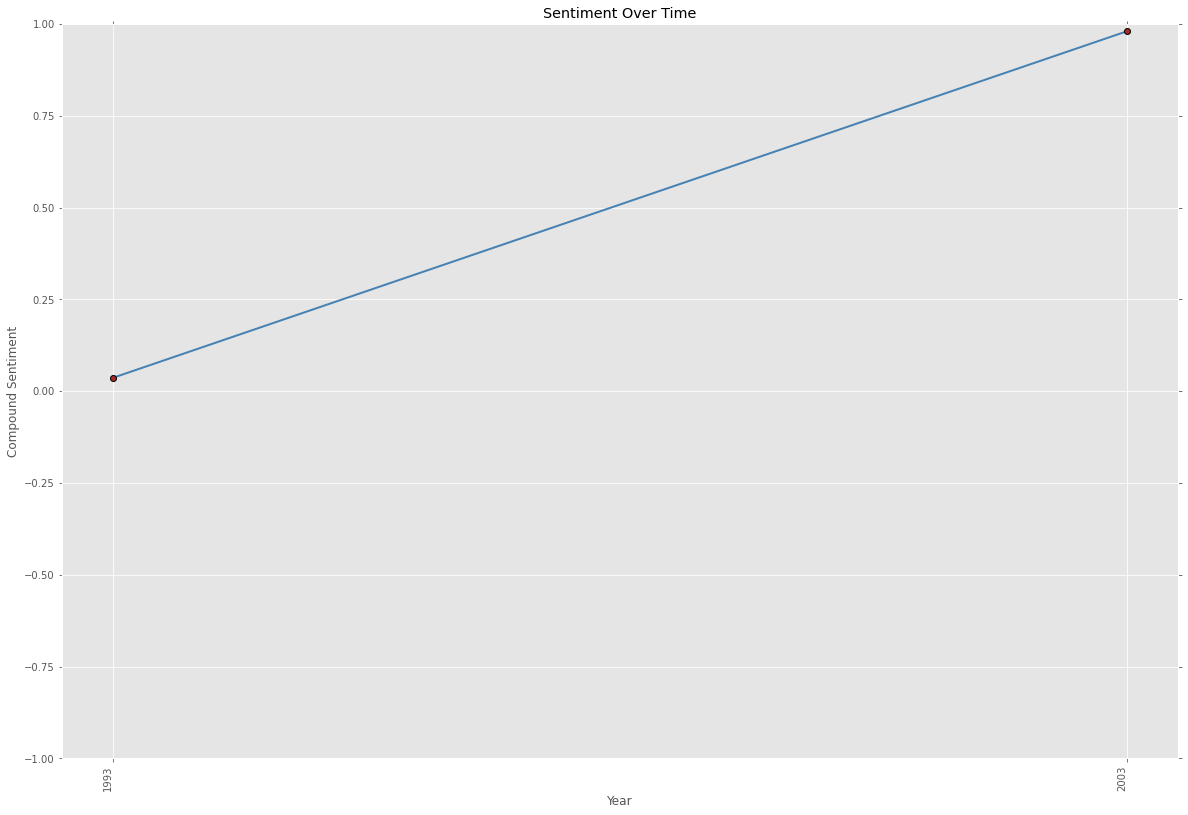

In [73]:
OvertimeAnalysis(data_QM_for_analysis)

# Main topics and themes in India

In [19]:
data_india = pd.read_csv("D:\\India Data.csv", encoding = 'ANSI', low_memory=False)

In [30]:
item_org_1, item_gpe_1 = ner(data_india[0:60], 9)

In [31]:
df_1 = data_india.iloc[60:100, :]
df_1 = df_1.reset_index(drop = True)
item_org_2, item_gpe_2 = ner(df_1, 9)

In [32]:
df_2 = data_india.iloc[100:200, :]
df_2 = df_2.reset_index(drop = True)
item_org_3, item_gpe_3 = ner(df_2, 9)

In [33]:
df_3 = data_india.iloc[200:300, :]
df_3 = df_3.reset_index(drop = True)
item_org_4, item_gpe_4 = ner(df_3, 9)

In [34]:
df_4 = data_india.iloc[300:360, :]
df_4 = df_4.reset_index(drop = True)
item_org_5, item_gpe_5 = ner(df_4, 9)

In [35]:
df_5 = data_india.iloc[360:400, :]
df_5 = df_5.reset_index(drop = True)
item_org_6, item_gpe_6 = ner(df_5, 9)

In [36]:
df_6 = data_india.iloc[400:458, :]
df_6 = df_6.reset_index(drop = True)
item_org_7, item_gpe_7 = ner(df_6, 9)

In [37]:
dict_item_org_1 = dict(item_org_1)
dict_item_org_2 = dict(item_org_2)
dict_item_org_3 = dict(item_org_3)
dict_item_org_4 = dict(item_org_4)
dict_item_org_5 = dict(item_org_5)
dict_item_org_6 = dict(item_org_6)
dict_item_org_7 = dict(item_org_7)

In [38]:
item_org_12 = merge_dict(dict_item_org_1, dict_item_org_2)
item_org_34 = merge_dict(dict_item_org_3, dict_item_org_4)
item_org_56 = merge_dict(dict_item_org_5, dict_item_org_6)
item_org_1234 = merge_dict(item_org_12, item_org_34)
item_org_567 = merge_dict(item_org_56, dict_item_org_7)
item_org_1234567 = merge_dict(item_org_1234, item_org_567)

In [39]:
item_org_1234567

{'the State Party': 1224,
 'World Heritage': 1246,
 'Committee': 2428,
 'the World Heritage Centre': 537,
 'the World Heritage Committee': 531,
 'Bureau': 777,
 'IUCN': 627,
 'ASI': 211,
 'the List of World Heritage': 320,
 'UNESCO': 378,
 'IMP': 87,
 'Group of Monuments': 62,
 'The State Party': 110,
 'The World Heritage Committee': 242,
 'the Advisory Bodies': 138,
 'The World Heritage Centre': 37,
 'Manas Wildlife Sanctuary': 86,
 'the Central Government': 42,
 'State': 148,
 'the State Government': 80,
 'WH': 57,
 'State Party': 67,
 'the Operational Guidelines': 94,
 'World Heritage Centre': 27,
 'Archaeological Sites & Remains': 20,
 'Manas': 65,
 'the Integrated Management Plan': 26,
 'Archaeological Survey of India': 41,
 'the State Government of': 25,
 'Manas National Park': 22,
 'Fatehpur Sikri': 62,
 'Siva': 28,
 'the World Heritage': 26,
 'the Bodoland Territorial Council': 22,
 'Park': 20,
 'UNESCO Extra-Budgetary Funds': 13,
 'World Heritage Centre/ICOMOS': 18,
 'WHF': 24

In [40]:
df_1 = capital_to_lower_combine(item_org_1234567)

In [41]:
df_1.to_csv('test_india.csv', encoding='UTF-8_sig')

In [112]:
data_India = pd.read_csv('C:\\Users\\86138\\Desktop\\aj_india.csv', encoding='ANSI')
data_India.head(1)

,Value,Organization
0,627,IUCN


In [113]:
dict_india = dict(zip(data_india_final['Organization'],data_india_final['Value']))
dict_india

{'IUCN': 627,
 'ASI': 211,
 'IMP': 87,
 'Manas wildlife Sanctuary': 87,
 'KNP': 86,
 'ICOMOS': 74,
 'RAPPORTEUR': 67,
 'Manas': 65,
 'Fatehpur Sikri': 62,
 'Group of Monuments': 62,
 'GHNP': 61,
 'WH': 57,
 'DHR': 52,
 'The Government of India': 51,
 'The Archaeological Survey of India': 49,
 'The Central Government': 46,
 'VoF': 44,
 'VI': 44,
 'ARCHAEOLOGICAL SURVEY OF INDIA': 42,
 'Le Corbusier': 35,
 'UNDP': 34,
 'ICCROM': 33,
 'KSR': 33,
 'The Darjeeling Himalayan Railway': 33,
 'the Archaeological Survey of': 33,
 'The World Bank': 30,
 'Durban': 30,
 'the Modern Movement': 29,
 'Khajuraho': 29,
 'THE BUREAU OF THE WORLD HERITAGE COMMITTEE': 28,
 'Siva': 28,
 'Archaeological Survey': 28,
 'MNP': 28,
 'The Integrated Management Plan': 27,
 'CST': 27,
 'The Mahabodhi Temple': 26,
 'The Mahabodhi Temple Complex': 26,
 'CULTURAL ORGANIZATION CONVENTION CONCERNING THE PROTECTION OF THE WORLD CULTURAL': 26,
 'SUN TEMPLE': 25,
 'Yamuna': 25,
 'Regrets': 24,
 'the Red Fort Complex': 24,


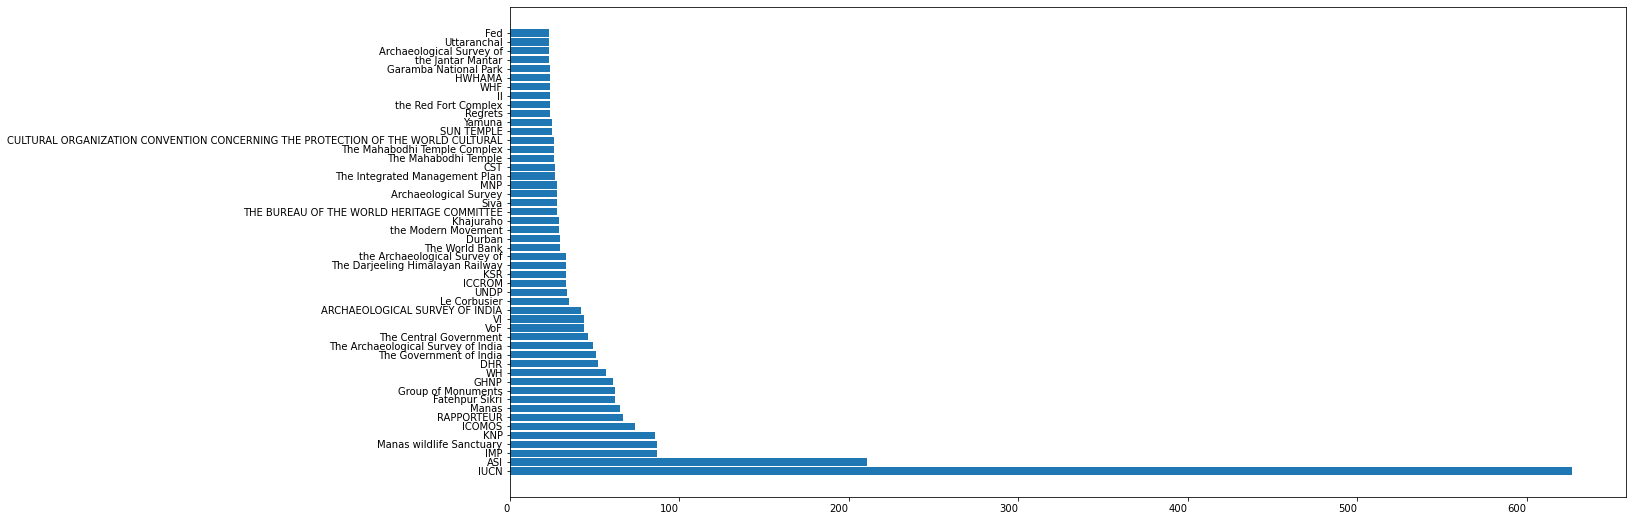

In [114]:
draw_from_dict(dict_india, 50, h = 1)

# Sentiment for Site

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\86138\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
data_india = pd.read_csv("D:\\India Data.csv", encoding = 'ANSI', low_memory=False)
data_india.head()

,country_name,country_link,site_name,site_link,coordinates,doc_title,doc_link,doc_year,doc_type,doc_content,...,Unnamed: 2992,Unnamed: 2993,Unnamed: 2994,Unnamed: 2995,Unnamed: 2996,Unnamed: 2997,Unnamed: 2998,Unnamed: 2999,Unnamed: 3000,Unnamed: 3001
0,India,https://whc.unesco.org/en/statesparties/in,Chhatrapati Shivaji Terminus (formerly Victori...,https://whc.unesco.org/en/list/945,N18 56 24.44 E72 50 10.33,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/154660,2004,ABevaluation,Chhatrapati Shivaji Terminus (India) No 945 re...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,India,https://whc.unesco.org/en/statesparties/in,Manas Wildlife Sanctuary,https://whc.unesco.org/en/list/338,N26 43 30 E91 1 50,Advisory Body Evaluation (IUCN),https://whc.unesco.org/document/153224,1985,ABevaluation,"a . 1 "" 1 A a i a q 7 1 i 1 4 4 鈥?f { 鈥?NOMINA...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,India,https://whc.unesco.org/en/statesparties/in,Great Living Chola Temples,https://whc.unesco.org/en/list/250,N10 46 59 E79 7 57,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/153042,2004,ABevaluation,Chola Temples (India) No 250 bis 1. BASIC DATA...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,India,https://whc.unesco.org/en/statesparties/in,Great Living Chola Temples,https://whc.unesco.org/en/list/250,N10 46 59 E79 7 57,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/153044,1987,ABevaluation,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,India,https://whc.unesco.org/en/statesparties/in,Ellora Caves,https://whc.unesco.org/en/list/243,N20 1 35.004 E75 10 45.012,Advisory Body Evaluation (ICOMOS) / 脡valuation...,https://whc.unesco.org/document/153028,1983,ABevaluation,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_india_for_analysis = data_india.iloc[:, [2,5,7,9]]
data_india_for_analysis.head(5)

,site_name,doc_title,doc_year,doc_content
0,Chhatrapati Shivaji Terminus (formerly Victori...,Advisory Body Evaluation (ICOMOS),2004,Chhatrapati Shivaji Terminus (India) No 945 re...
1,Manas Wildlife Sanctuary,Advisory Body Evaluation (IUCN),1985,"a . 1 "" 1 A a i a q 7 1 i 1 4 4 鈥?f { 鈥?NOMINA..."
2,Great Living Chola Temples,Advisory Body Evaluation (ICOMOS),2004,Chola Temples (India) No 250 bis 1. BASIC DATA...
3,Great Living Chola Temples,Advisory Body Evaluation (ICOMOS),1987,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...
4,Ellora Caves,Advisory Body Evaluation (ICOMOS) / 脡valuation...,1983,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...


In [14]:
(data_india_for_analysis['site_name'].unique())

array(['Chhatrapati Shivaji Terminus (formerly Victoria Terminus)',
       'Manas Wildlife Sanctuary', 'Great Living Chola Temples',
       'Ellora Caves', 'Elephanta Caves', 'Buddhist Monuments at Sanchi',
       'Champaner-Pavagadh Archaeological Park', 'Ajanta Caves',
       'Archaeological Site of Nalanda Mahavihara at Nalanda, Bihar',
       'Keoladeo National Park', 'Fatehpur Sikri', 'Agra Fort',
       'Khangchendzonga National Park', 'Western Ghats',
       'Nanda Devi and Valley of Flowers National Parks  ',
       'Sundarbans National Park', 'Mountain Railways of India',
       'Qutb Minar and its Monuments, Delhi',
       'Rani-ki-Vav (the Queen鈥檚 Stepwell) at Patan, Gujarat',
       'Red Fort Complex', 'Rock Shelters of Bhimbetka',
       'Mahabodhi Temple Complex at Bodh Gaya', 'Sun Temple, Kon芒rak',
       'Taj Mahal', 'Historic City of Ahmadabad',
       'Jaipur City, Rajasthan', "Humayun's Tomb, Delhi",
       'Victorian Gothic and Art Deco Ensembles of Mumbai',
       

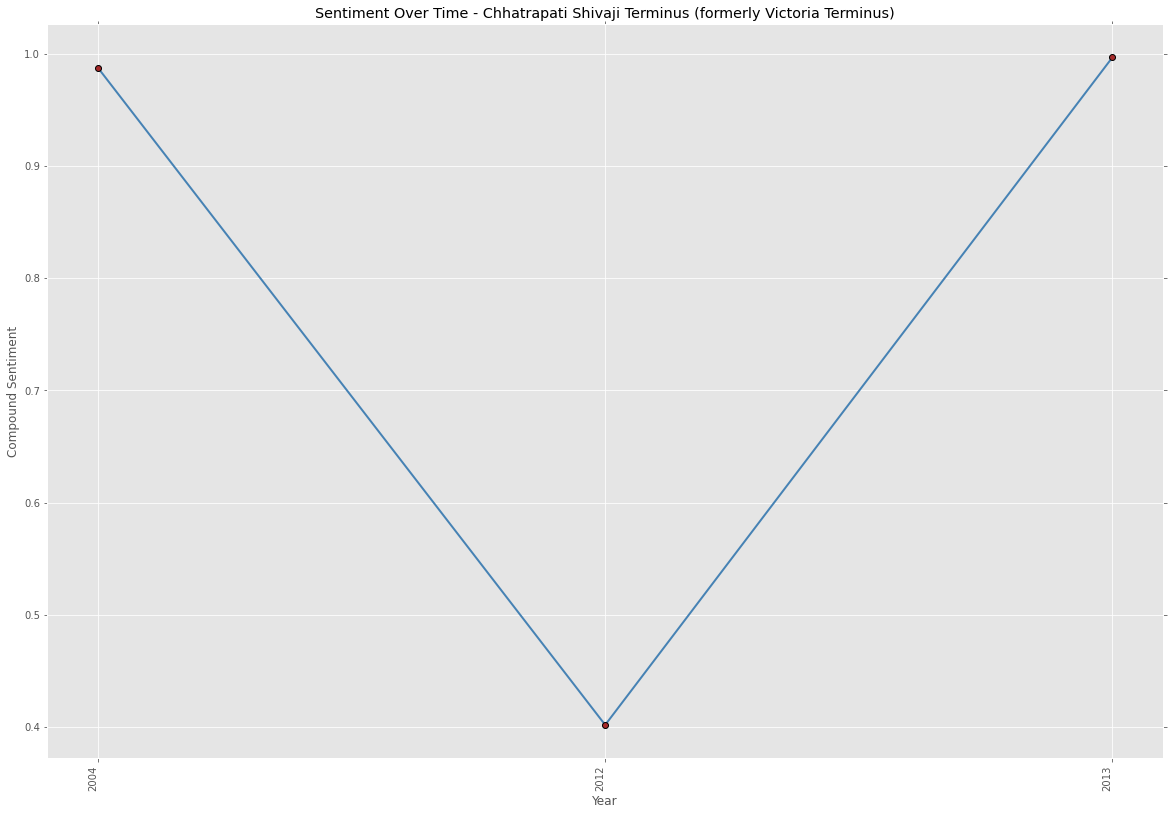

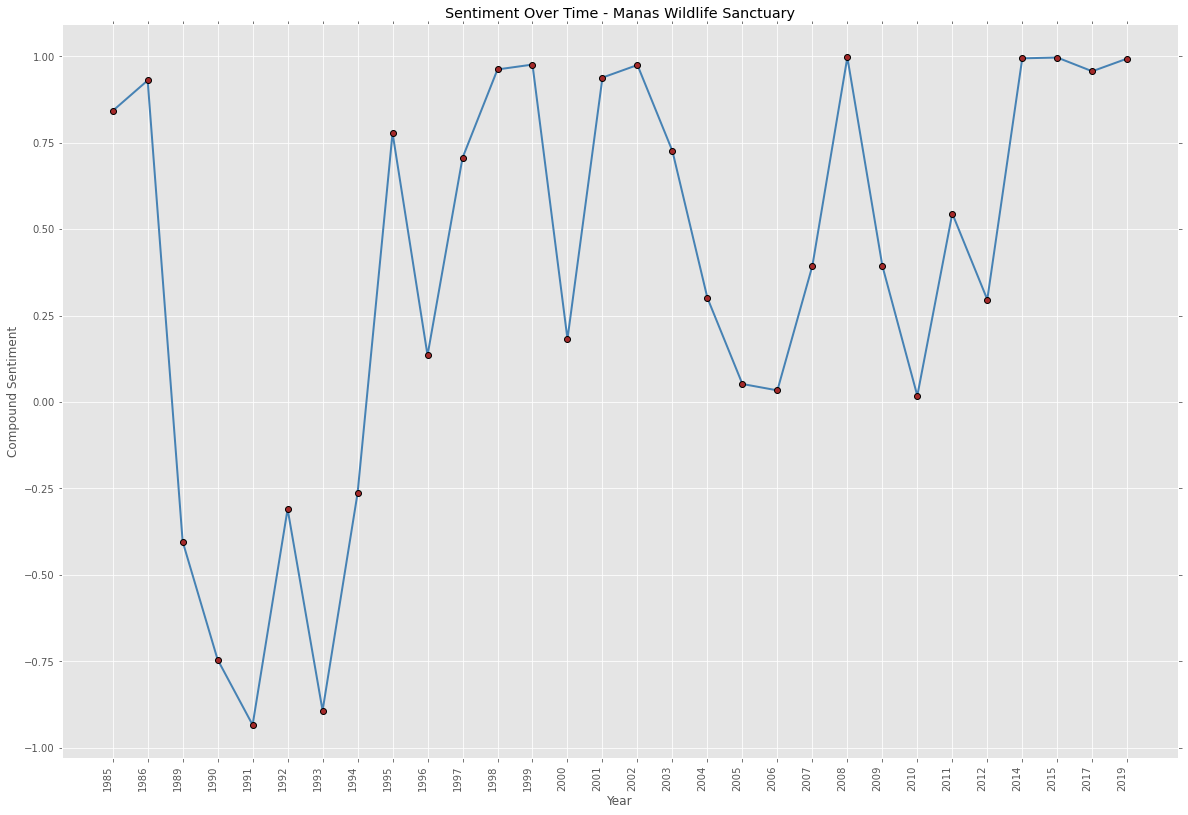

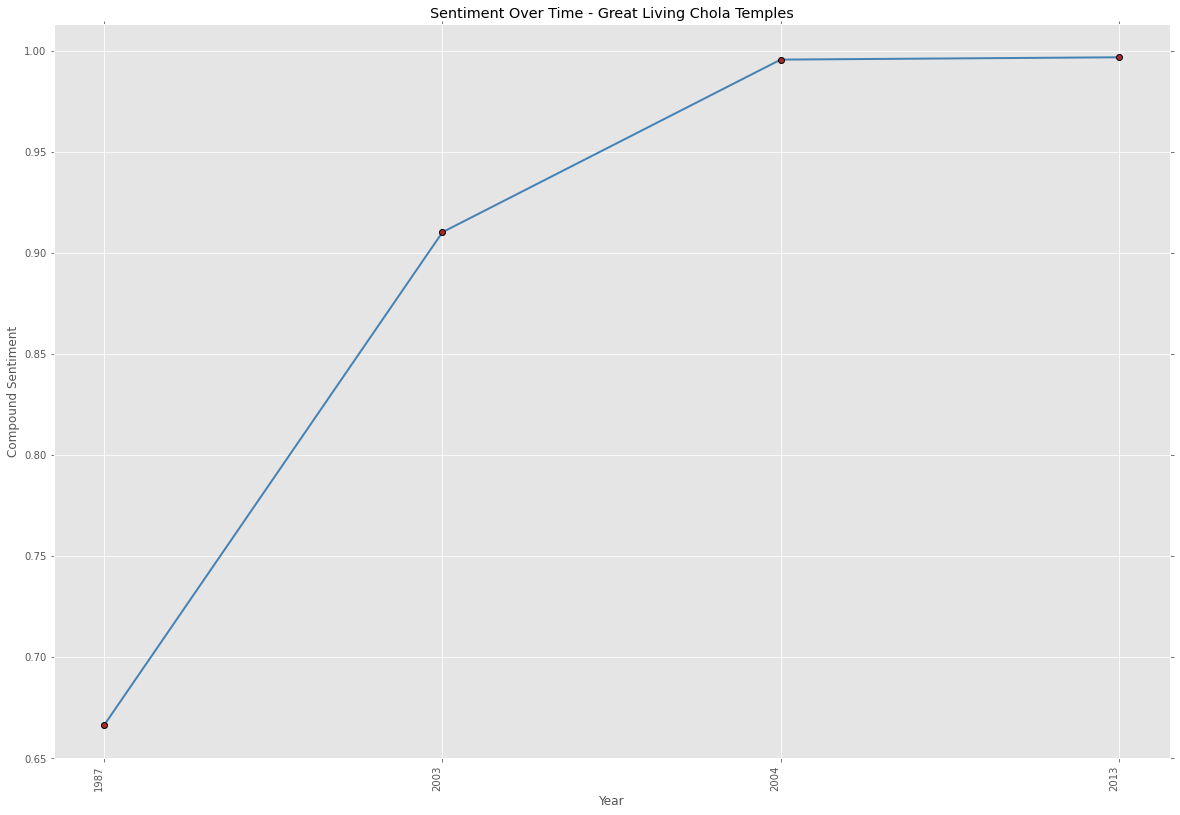

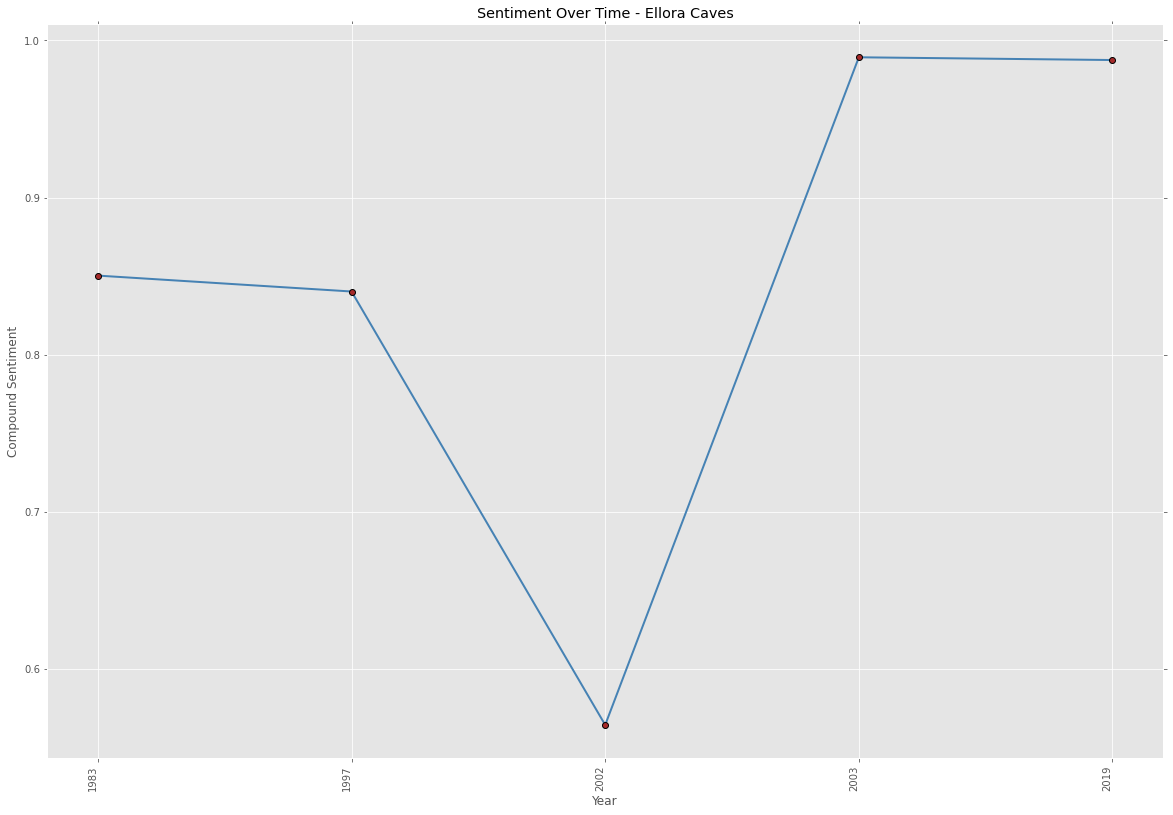

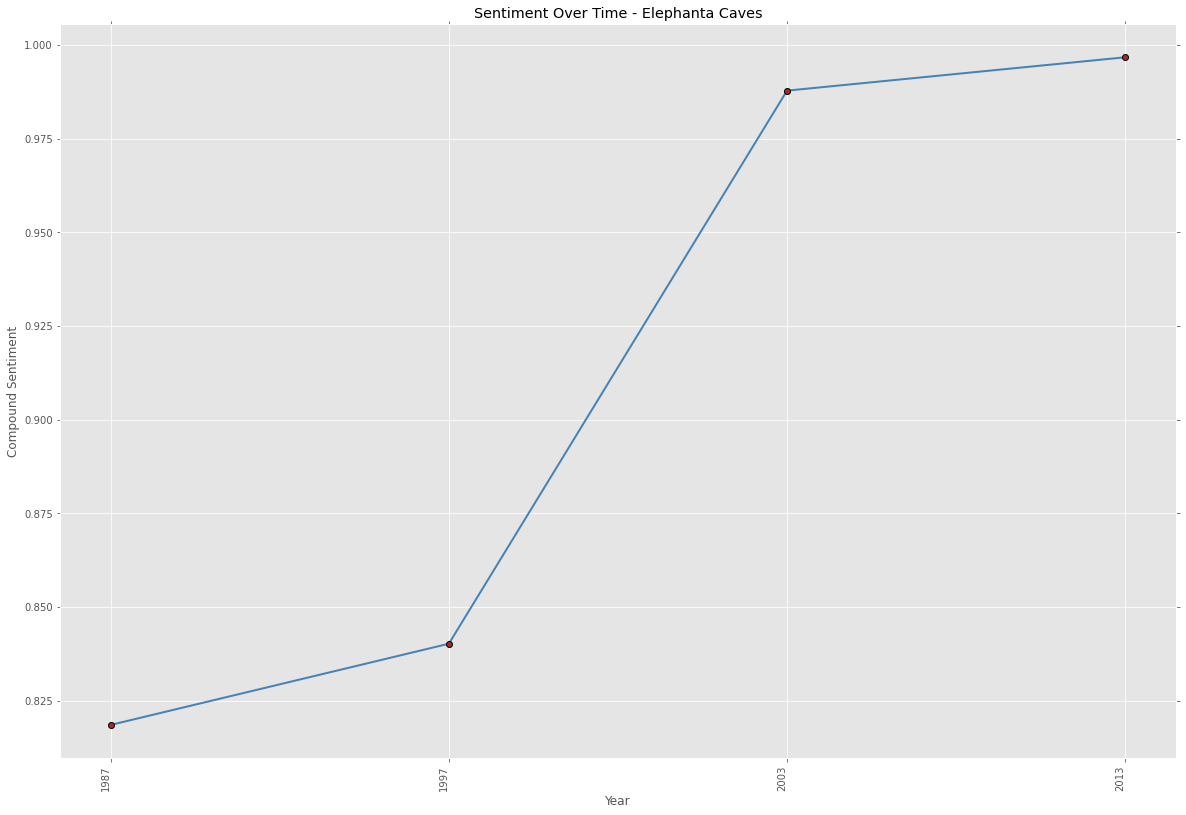

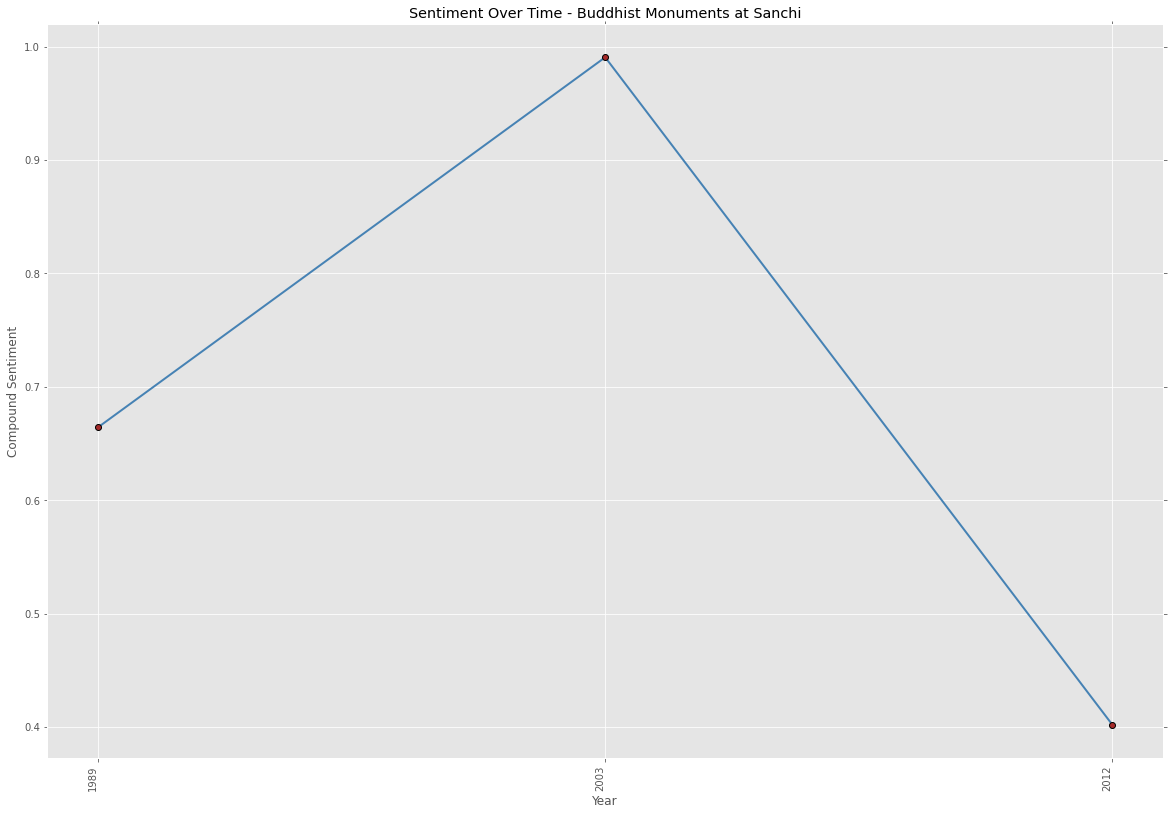

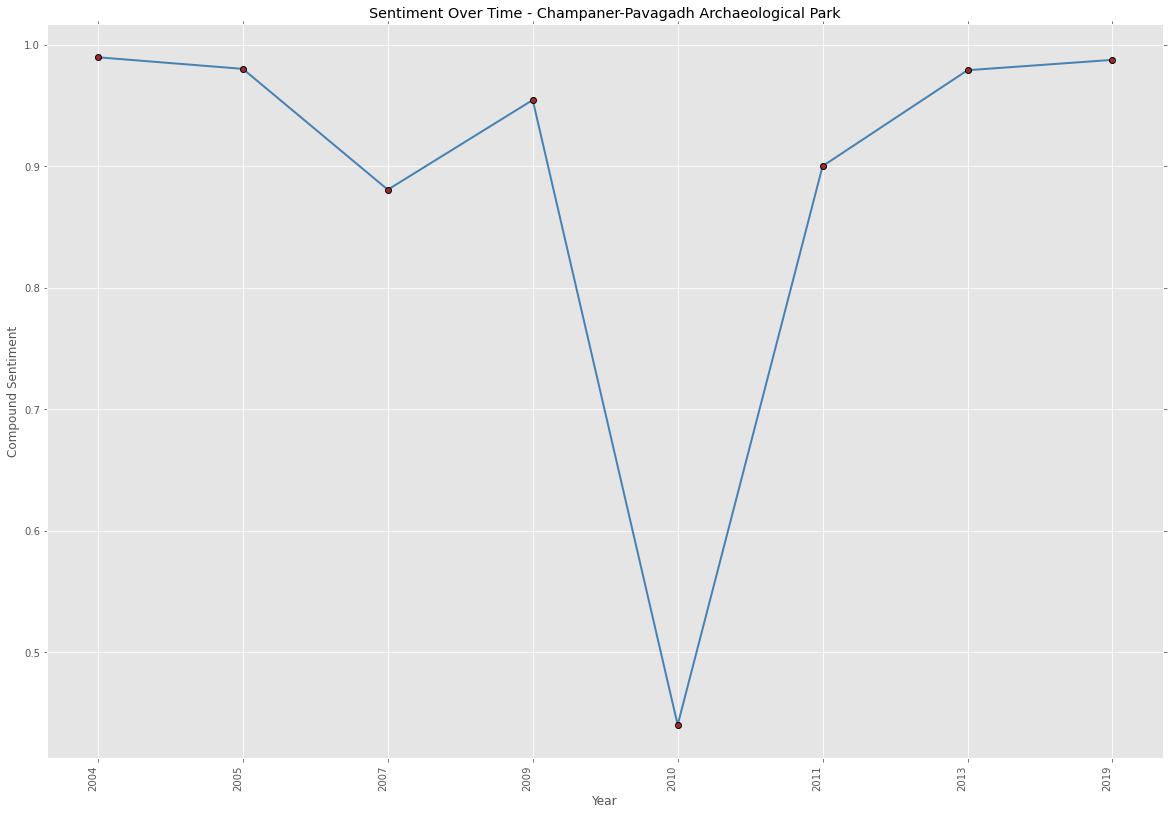

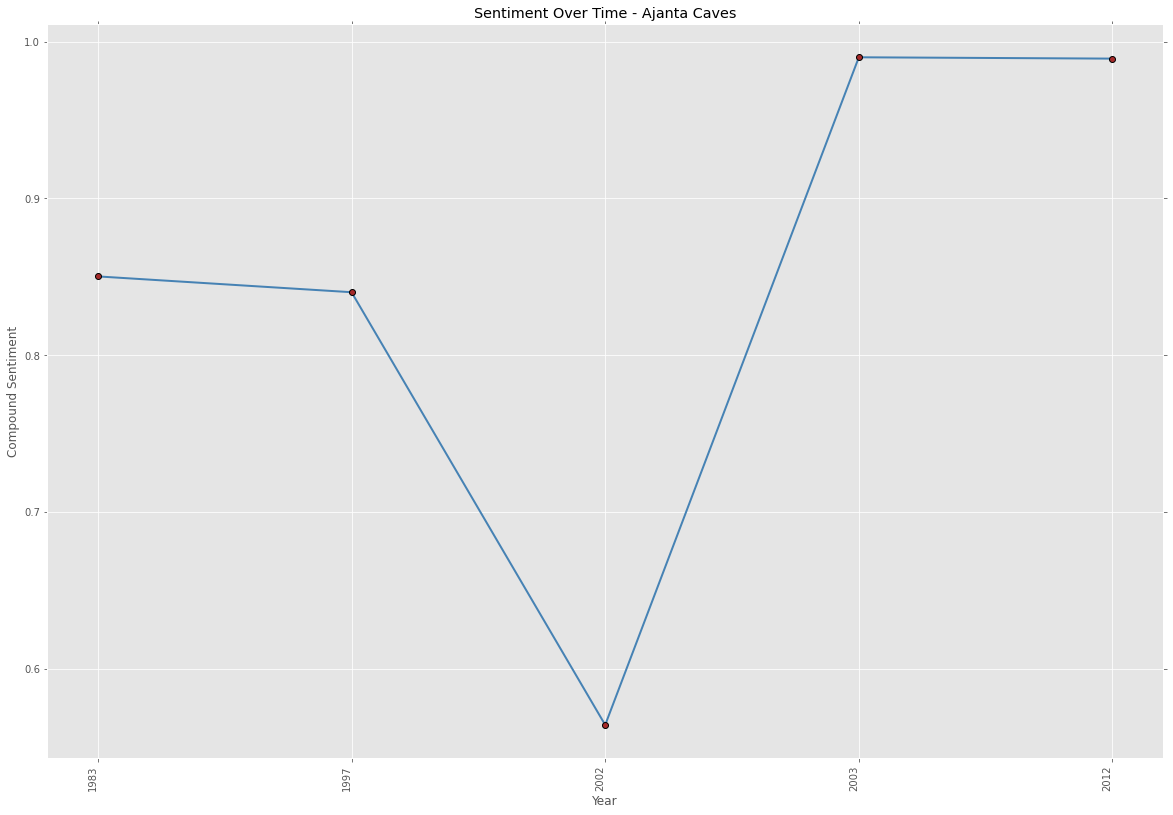

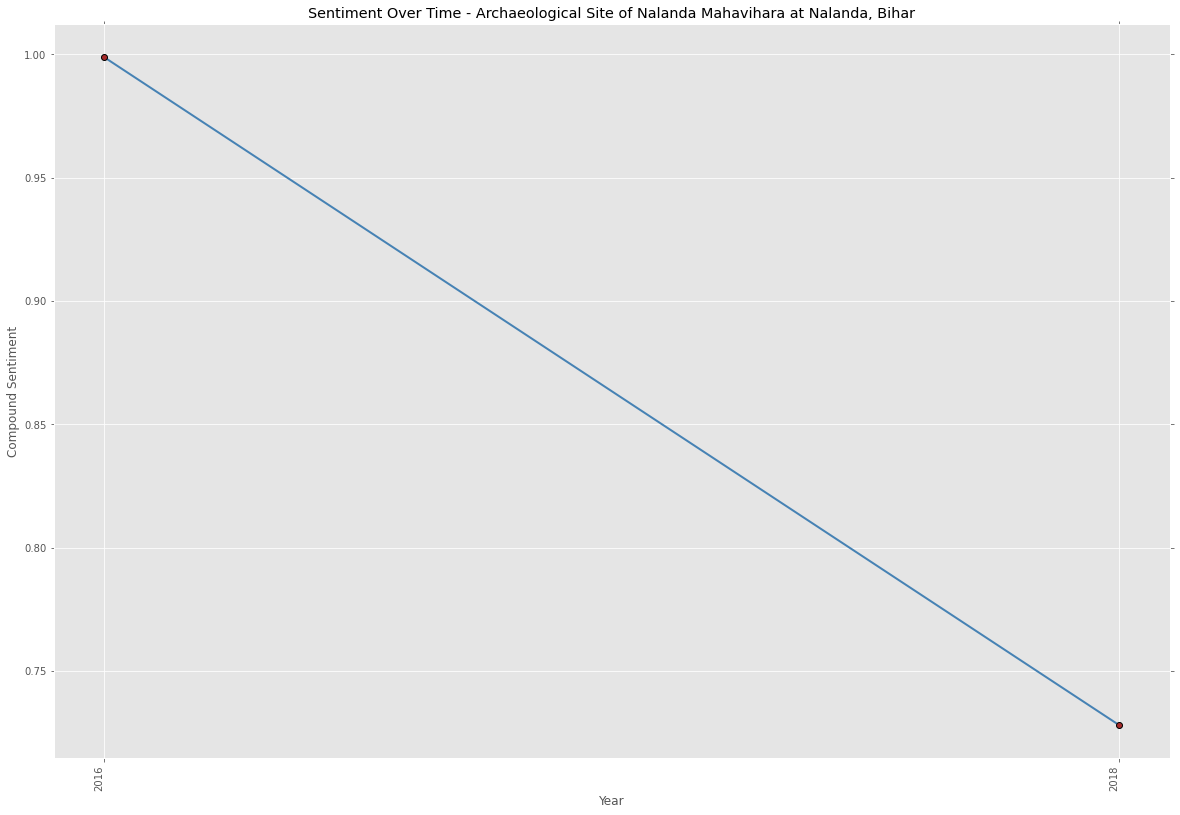

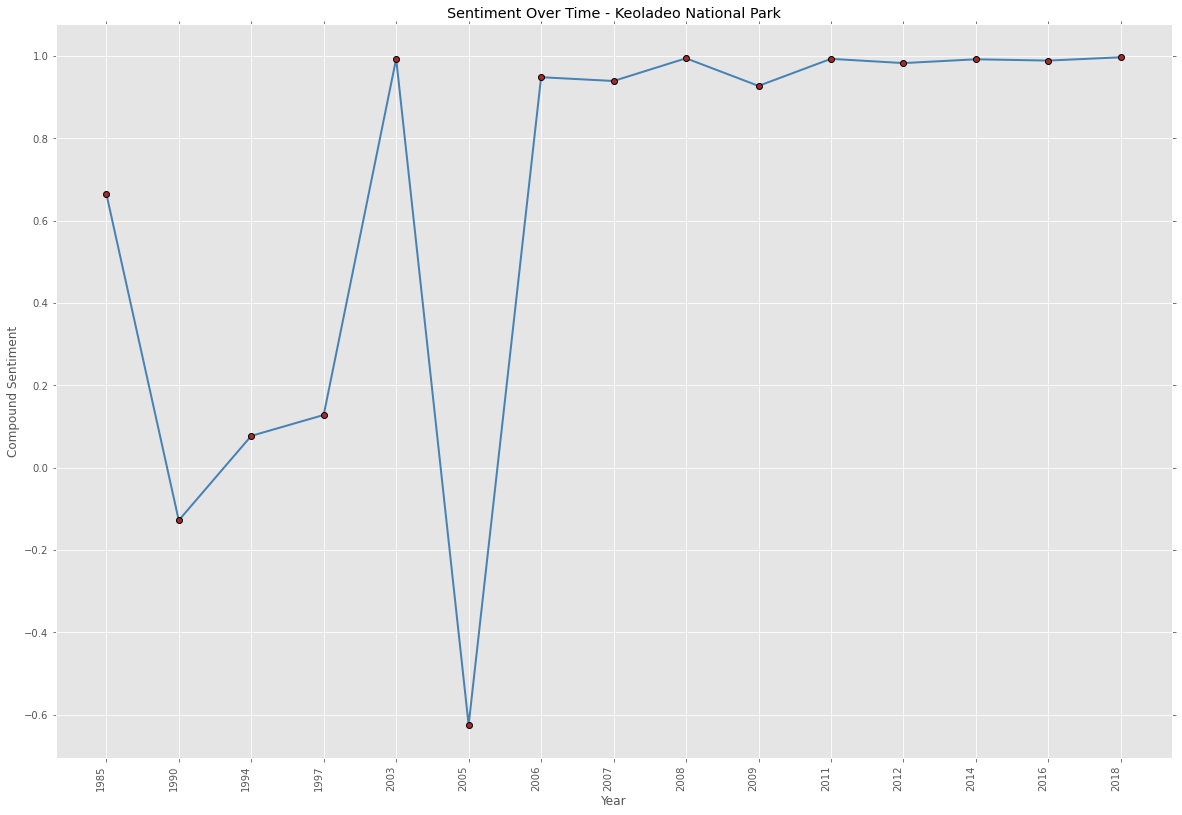

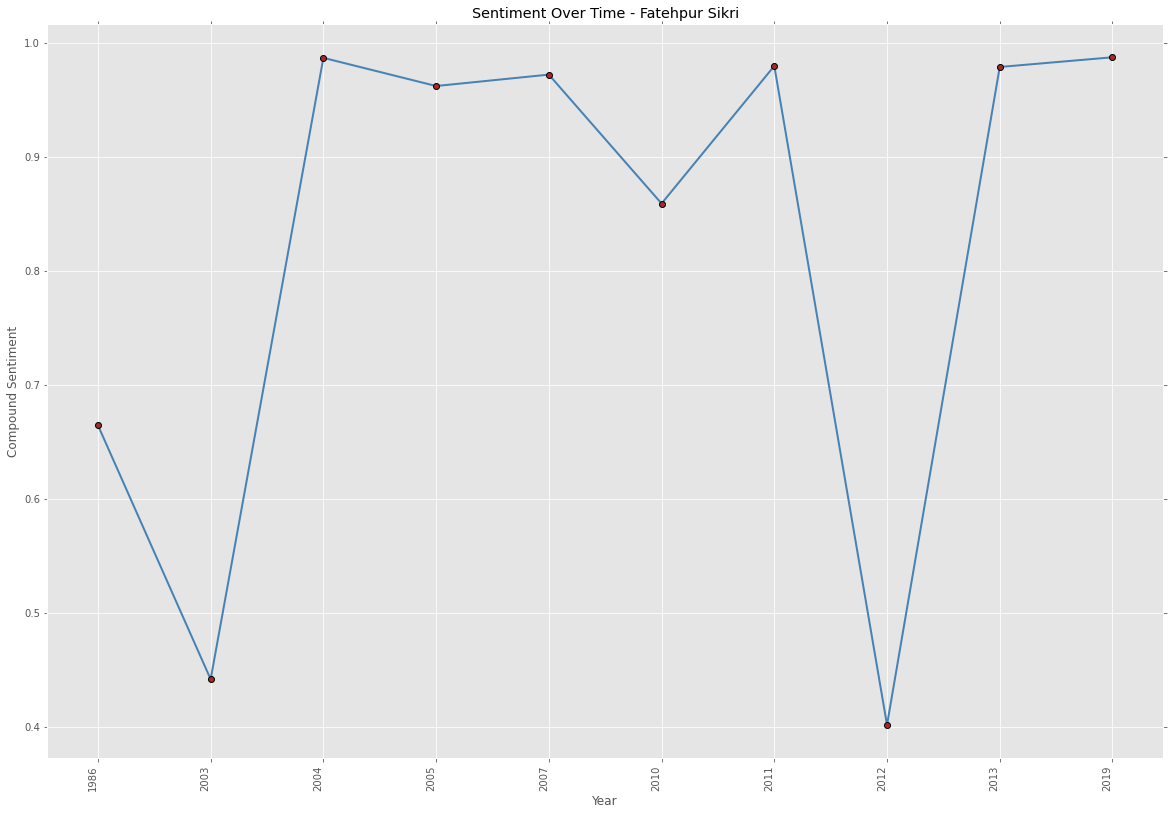

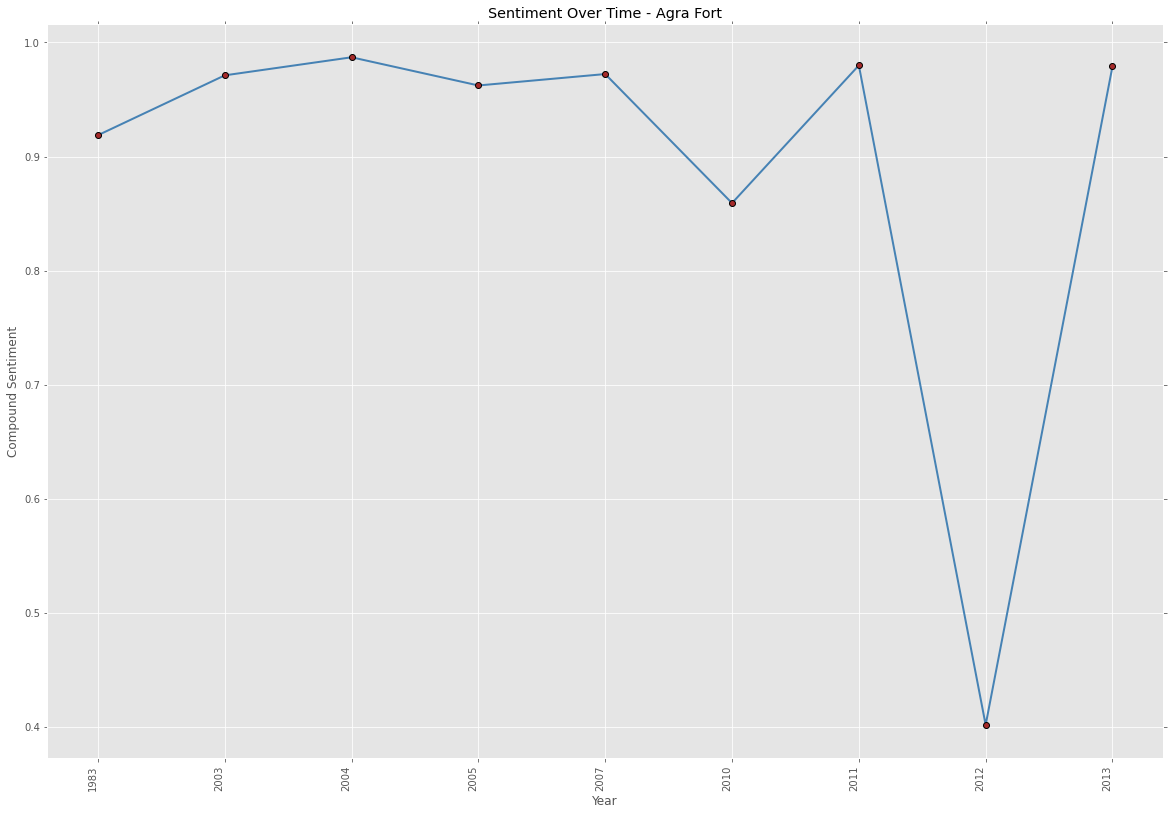

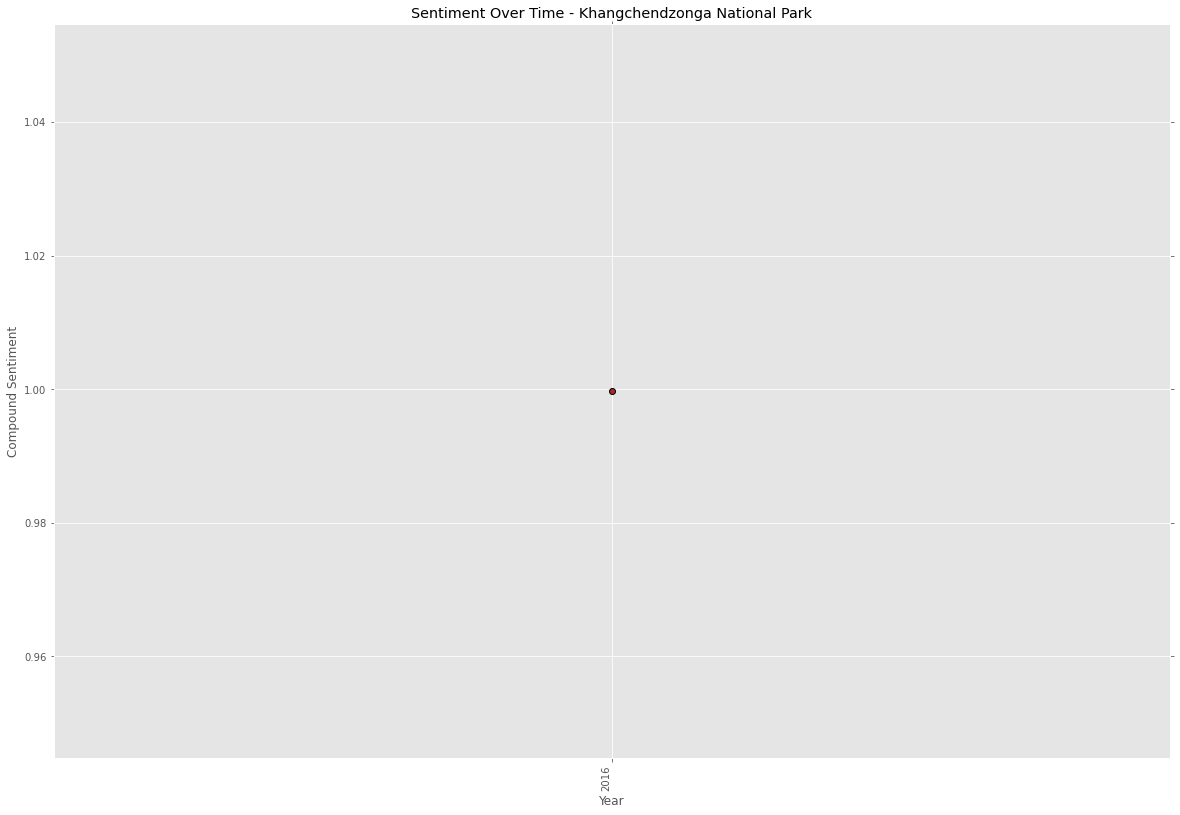

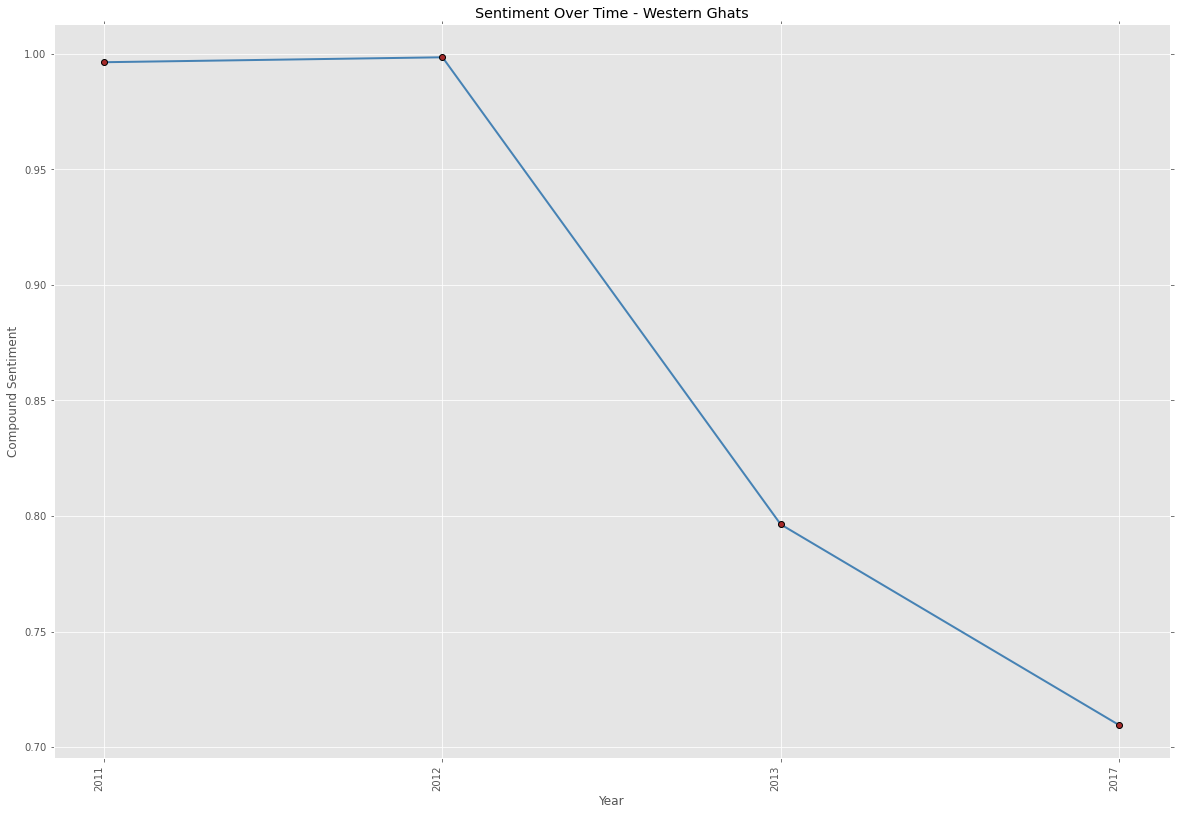

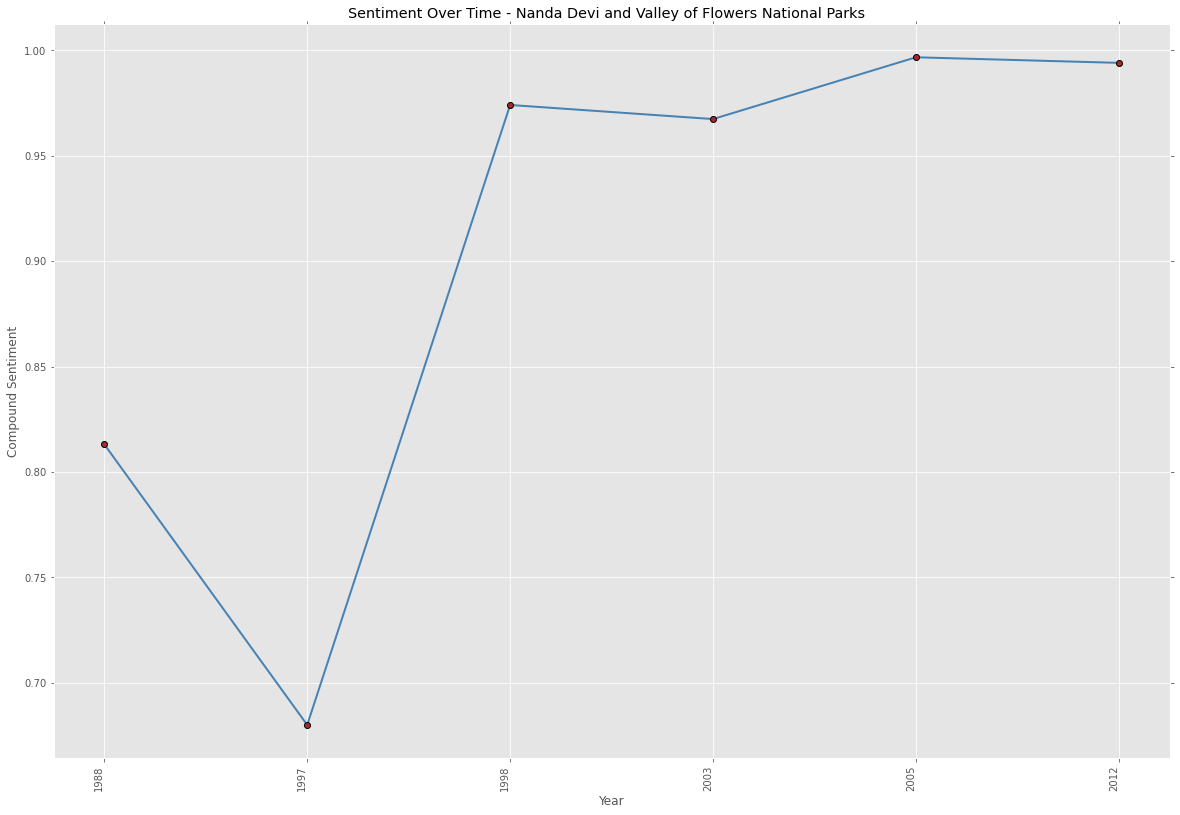

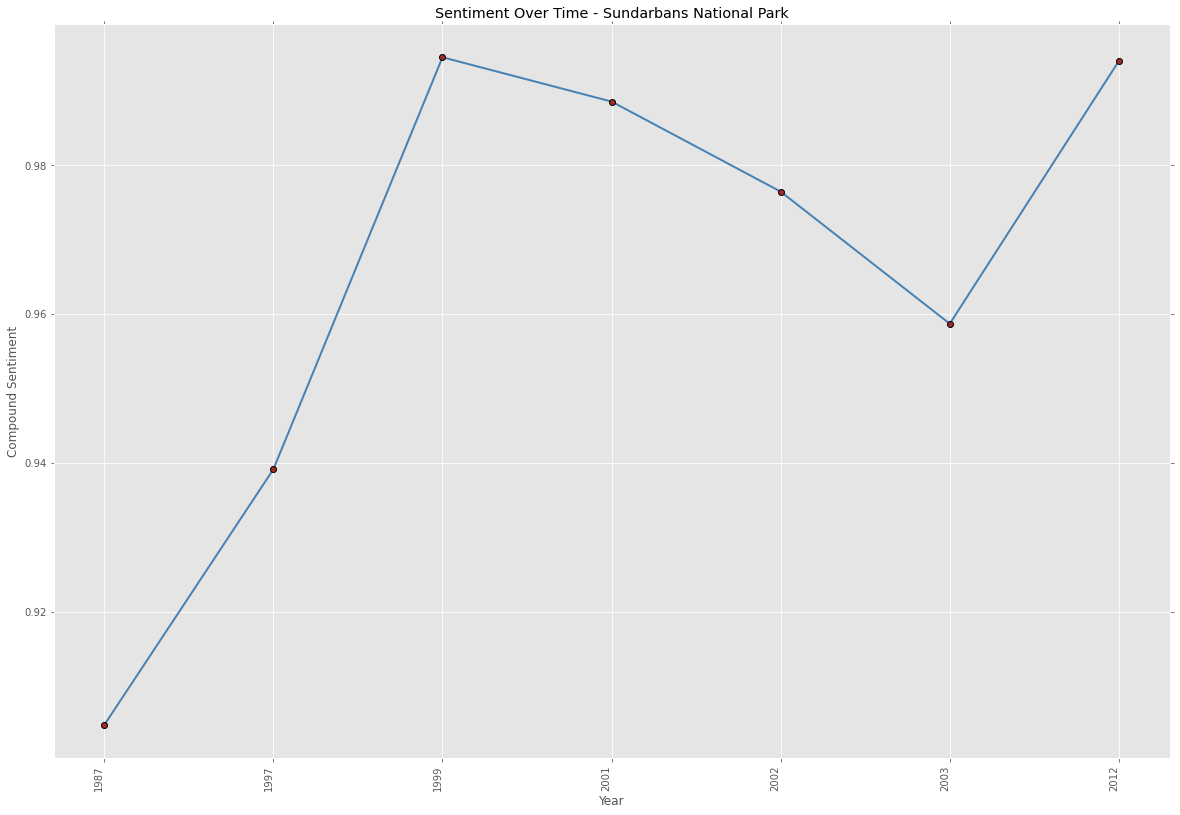

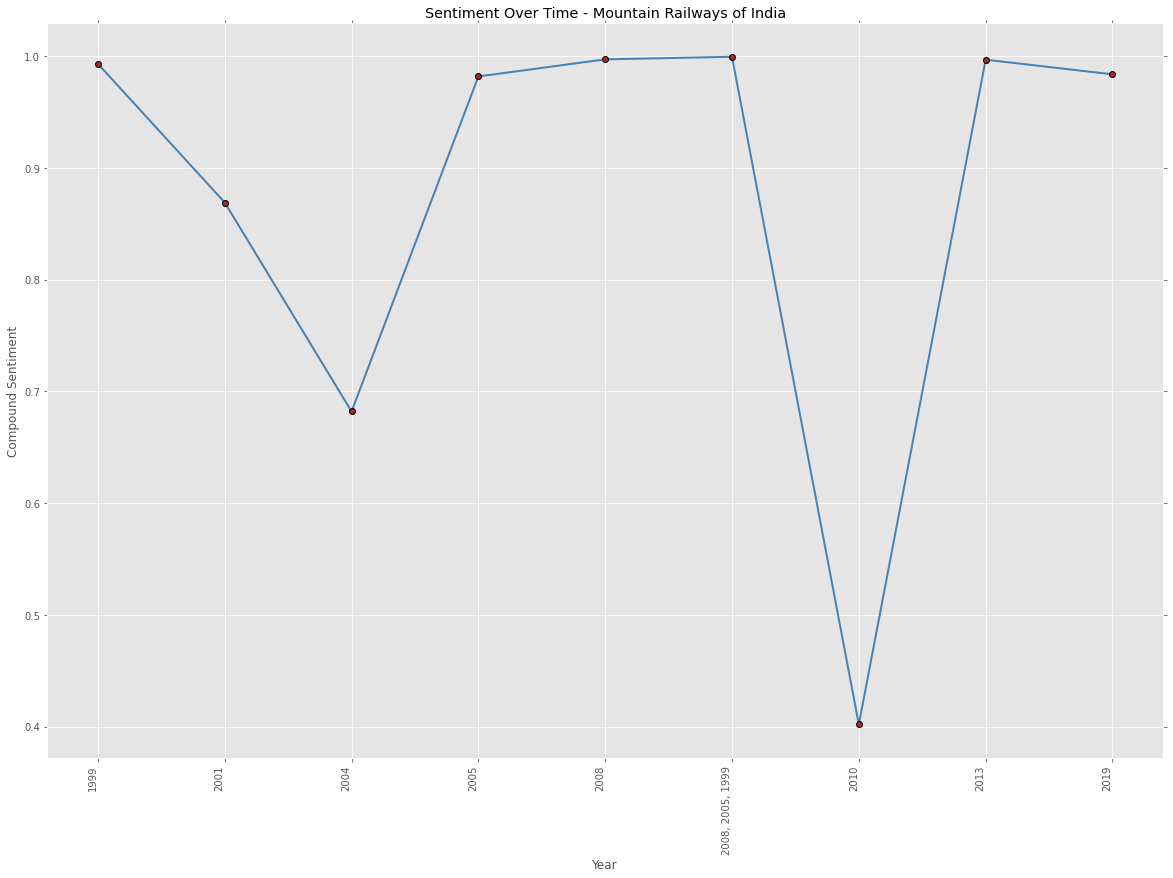

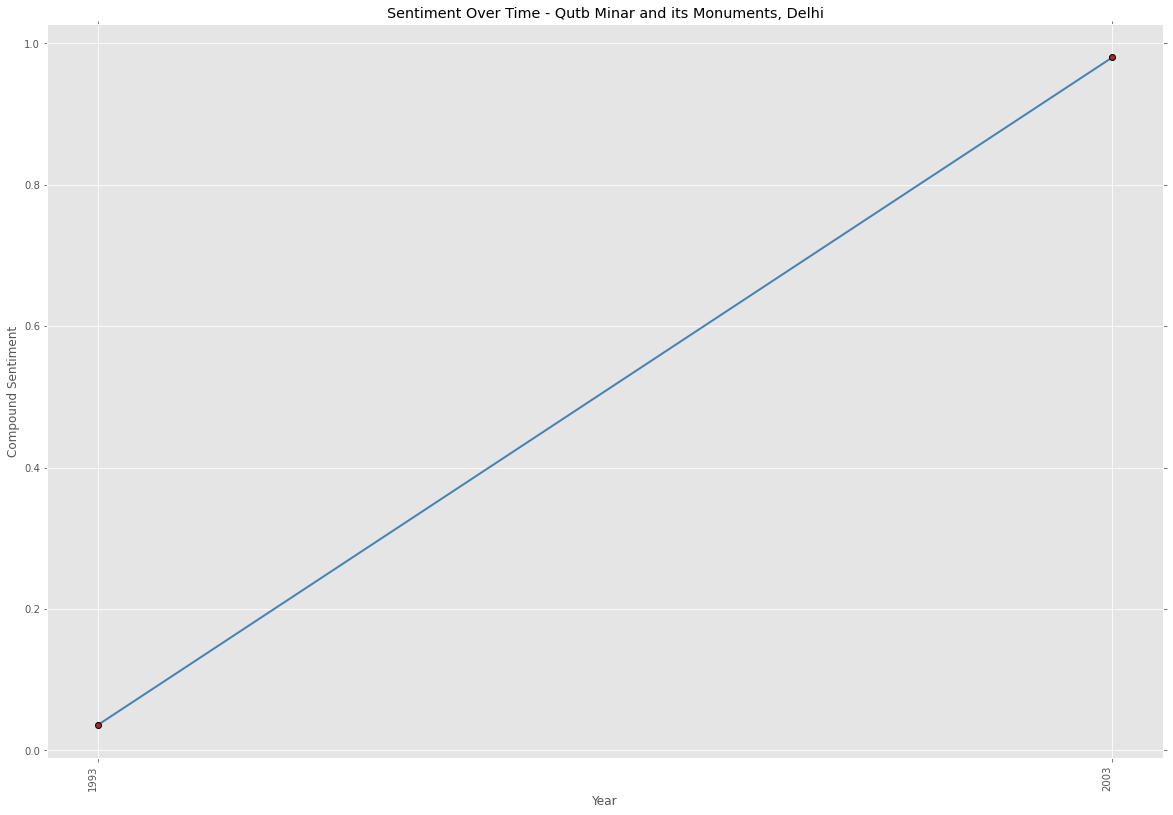

C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\matplotlib\textpath.py:84: RuntimeWarning: Glyph 37413 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\matplotlib\textpath.py:84: RuntimeWarning: Glyph 27290 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37413 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 27290 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37413 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\86138\AppData\Roaming\Python\Pytho

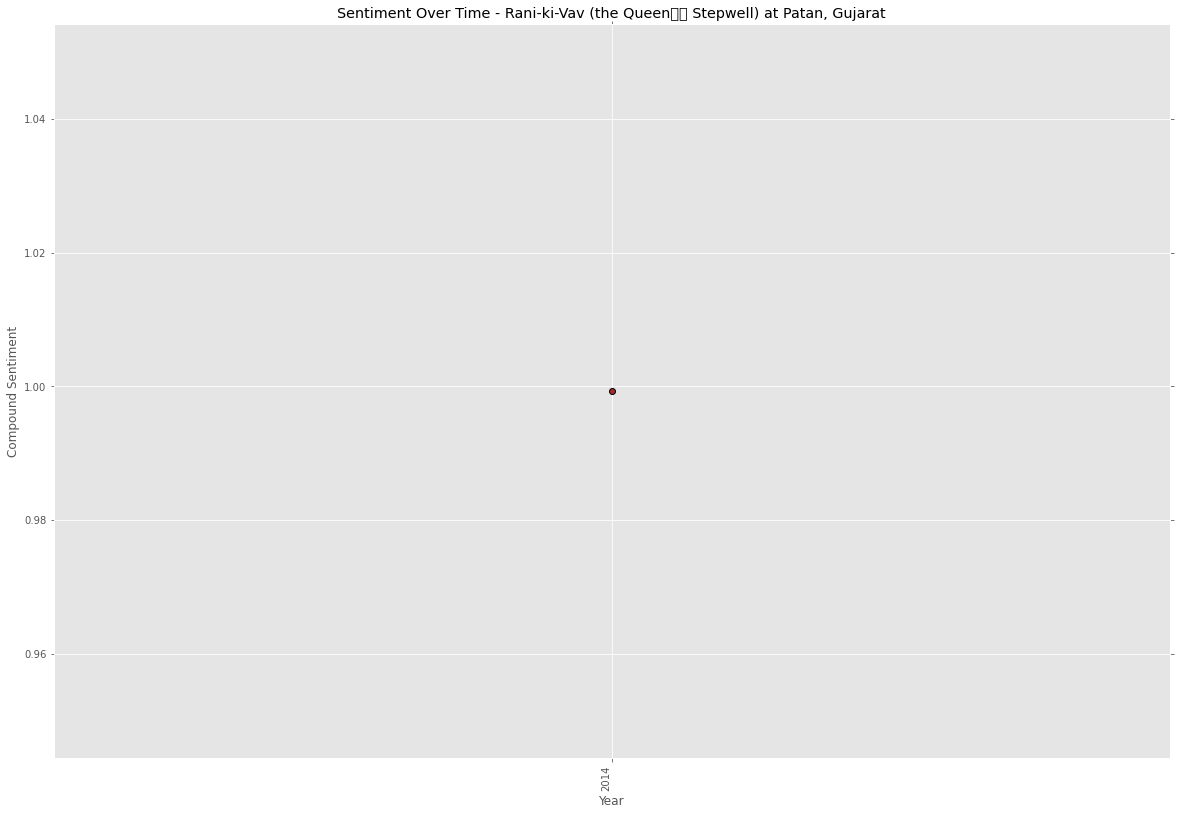

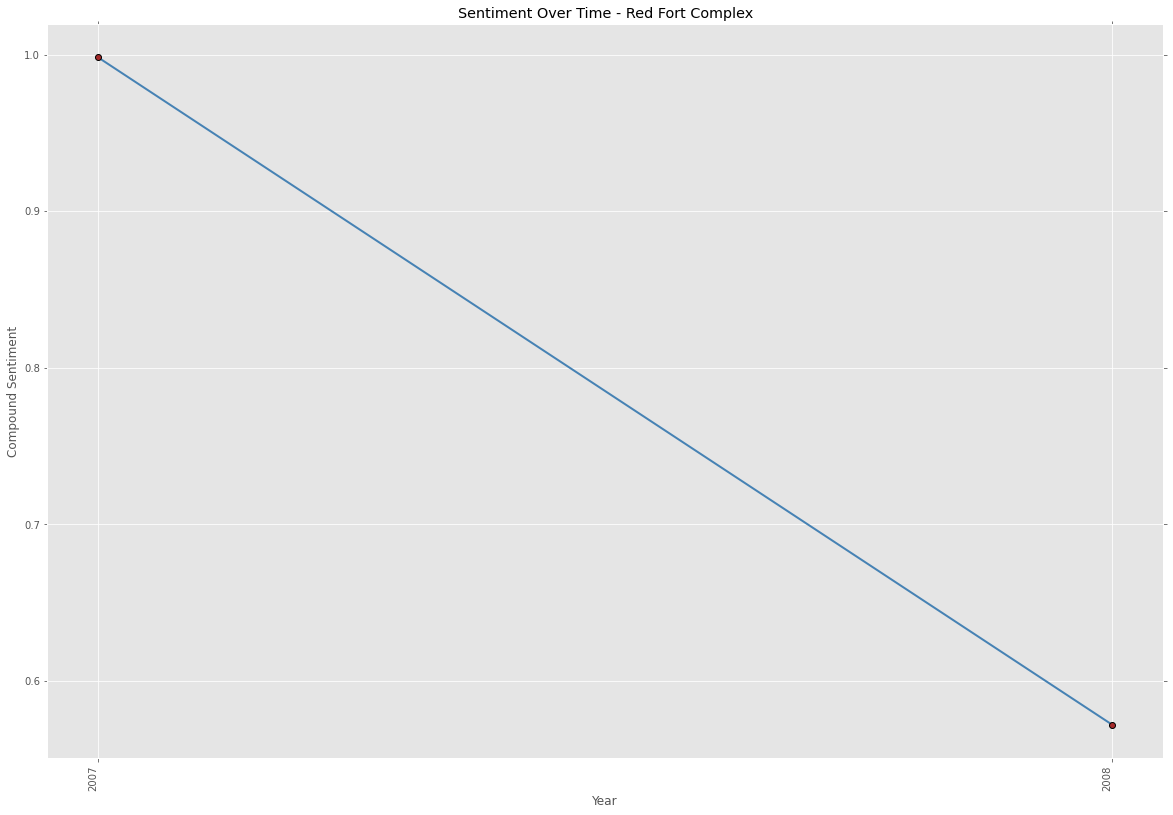

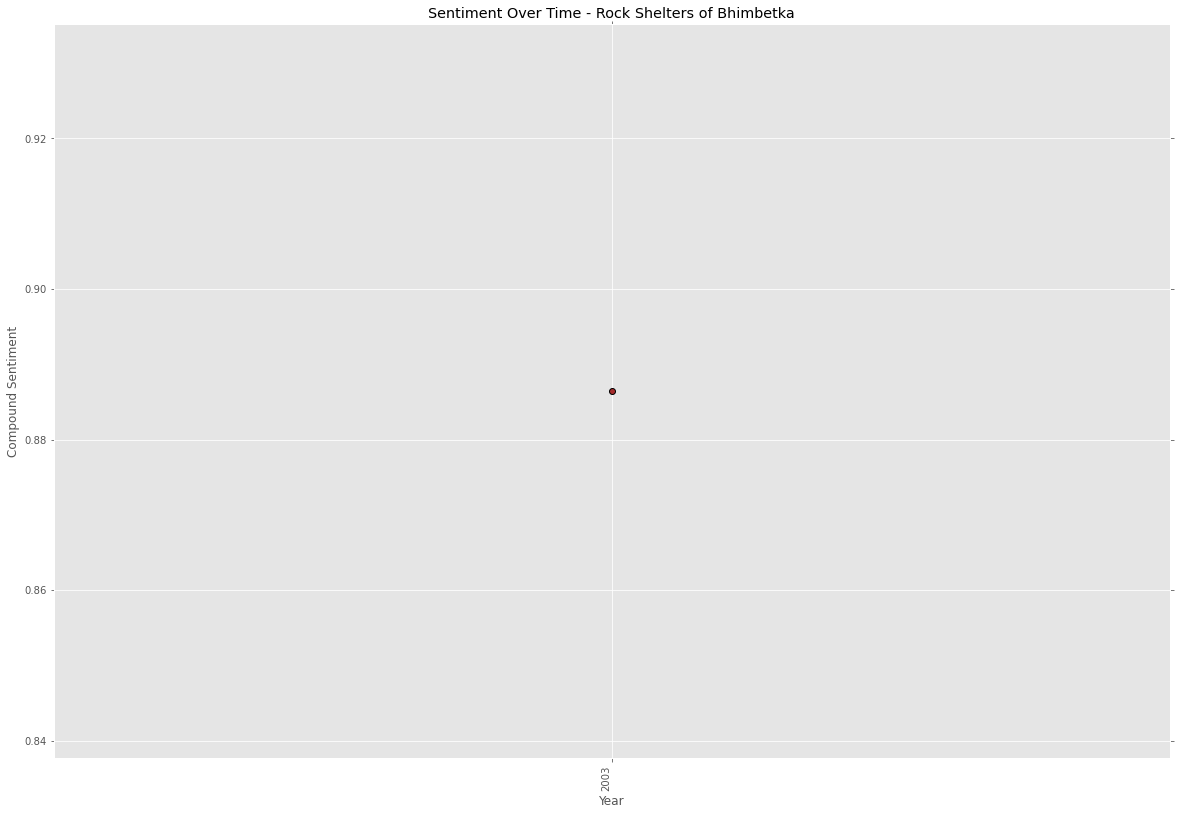

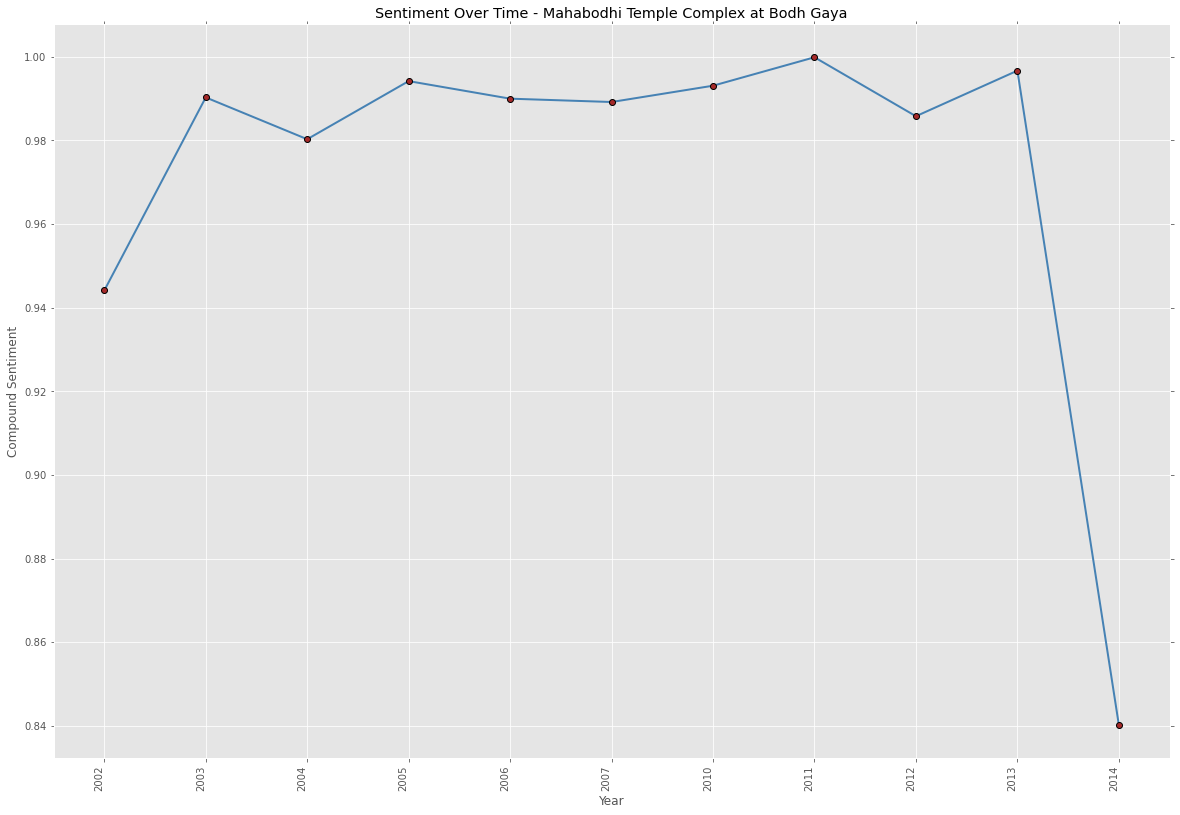

C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\matplotlib\textpath.py:84: RuntimeWarning: Glyph 33426 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 33426 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 33426 missing from current font.
  font.set_text(s, 0, flags=flags)


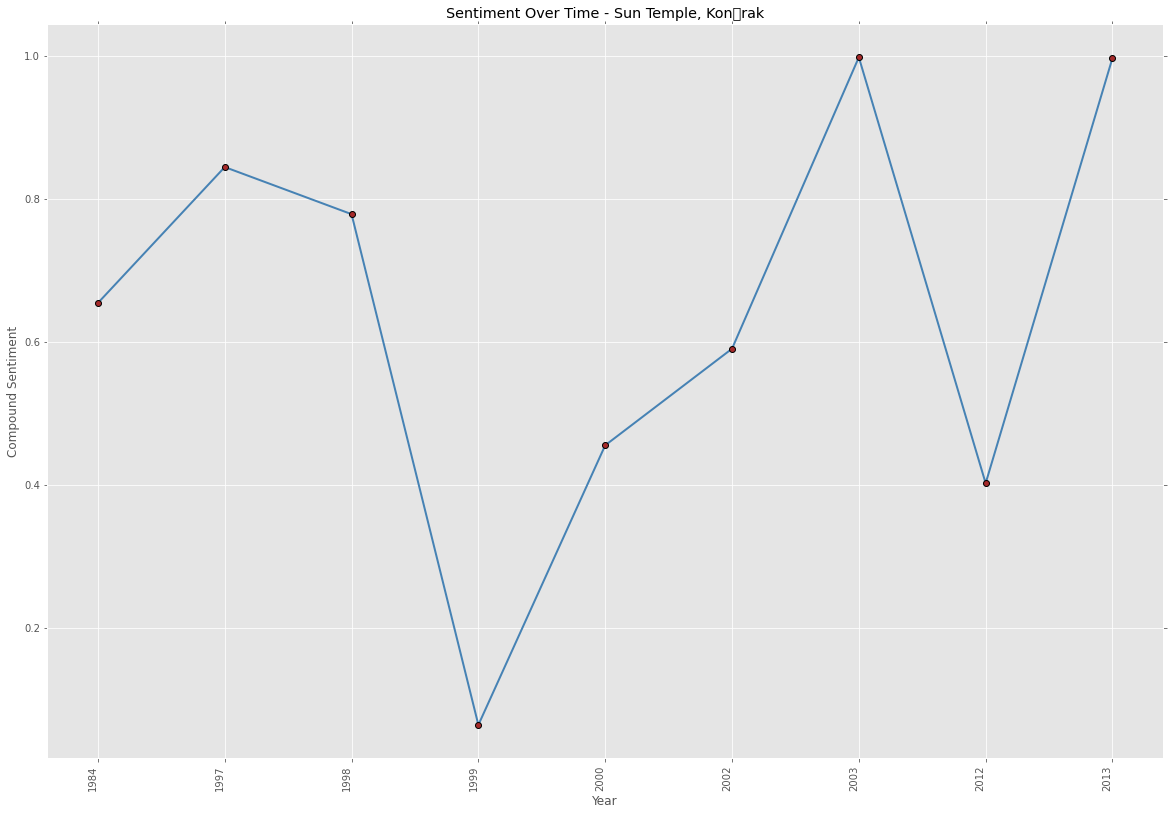

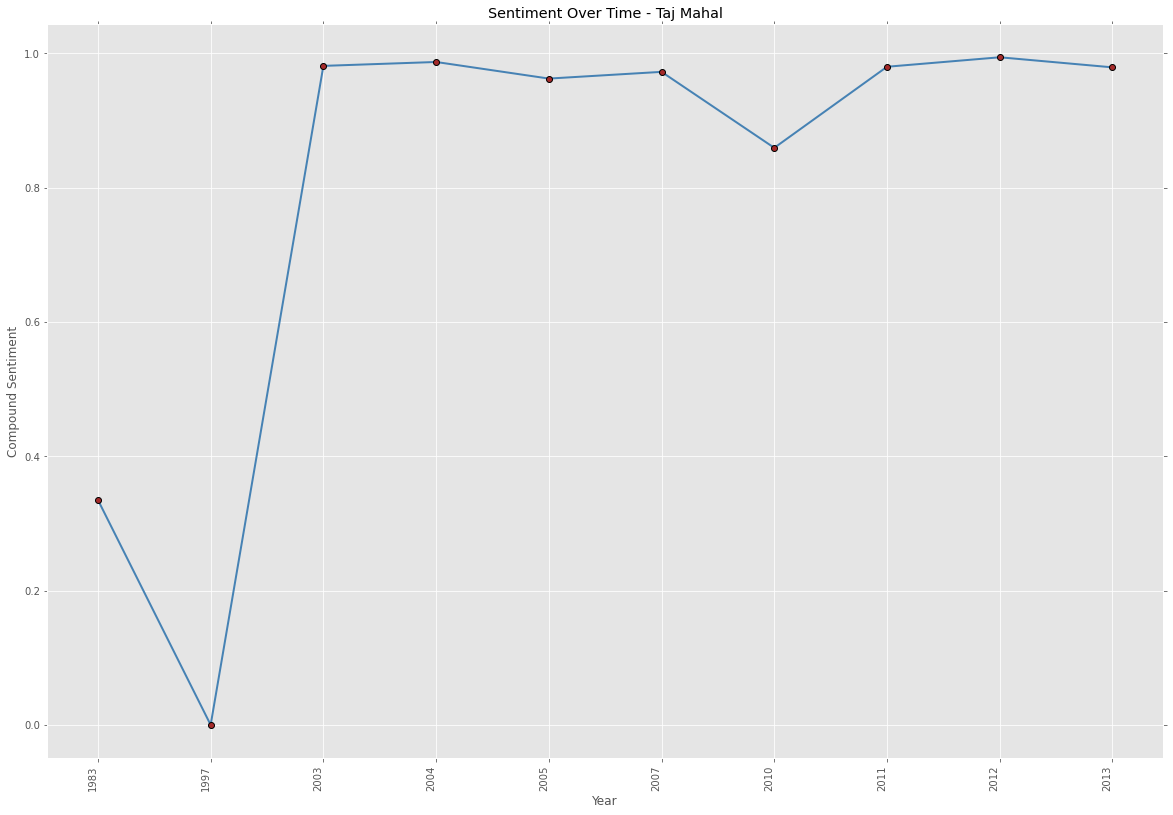

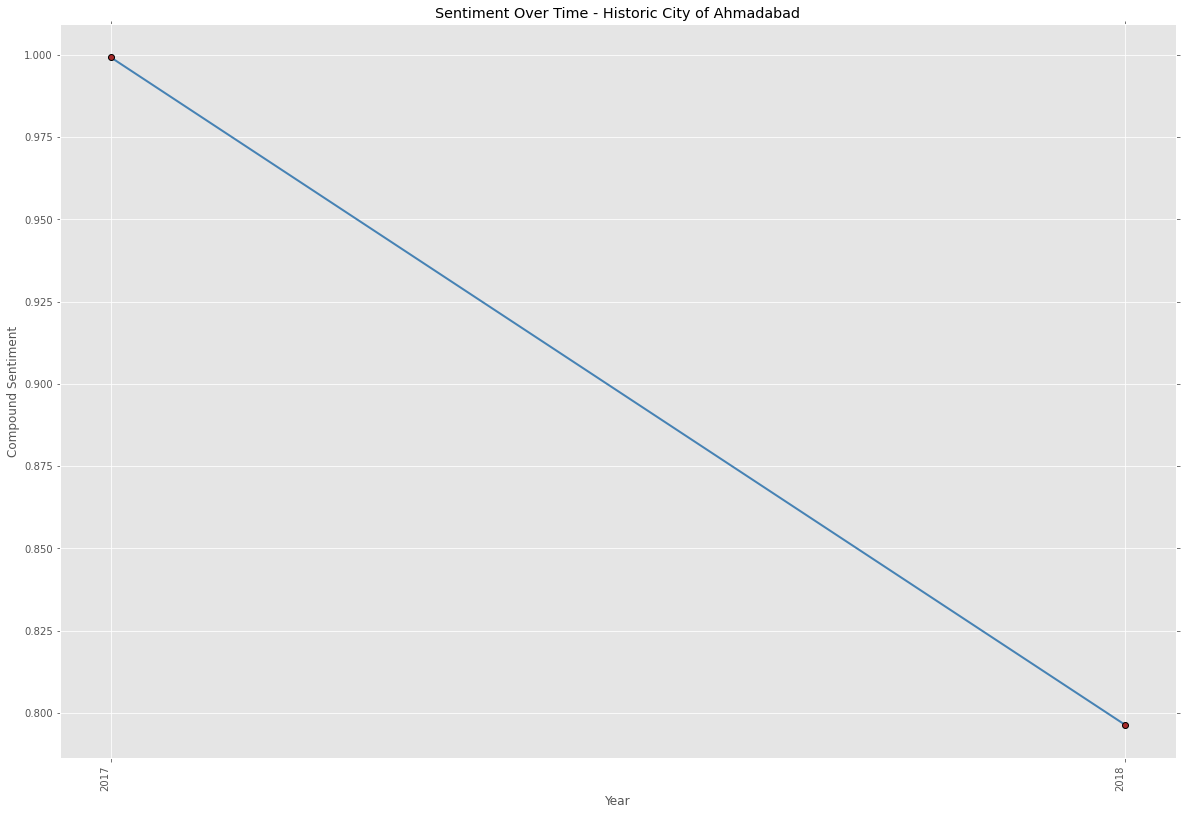

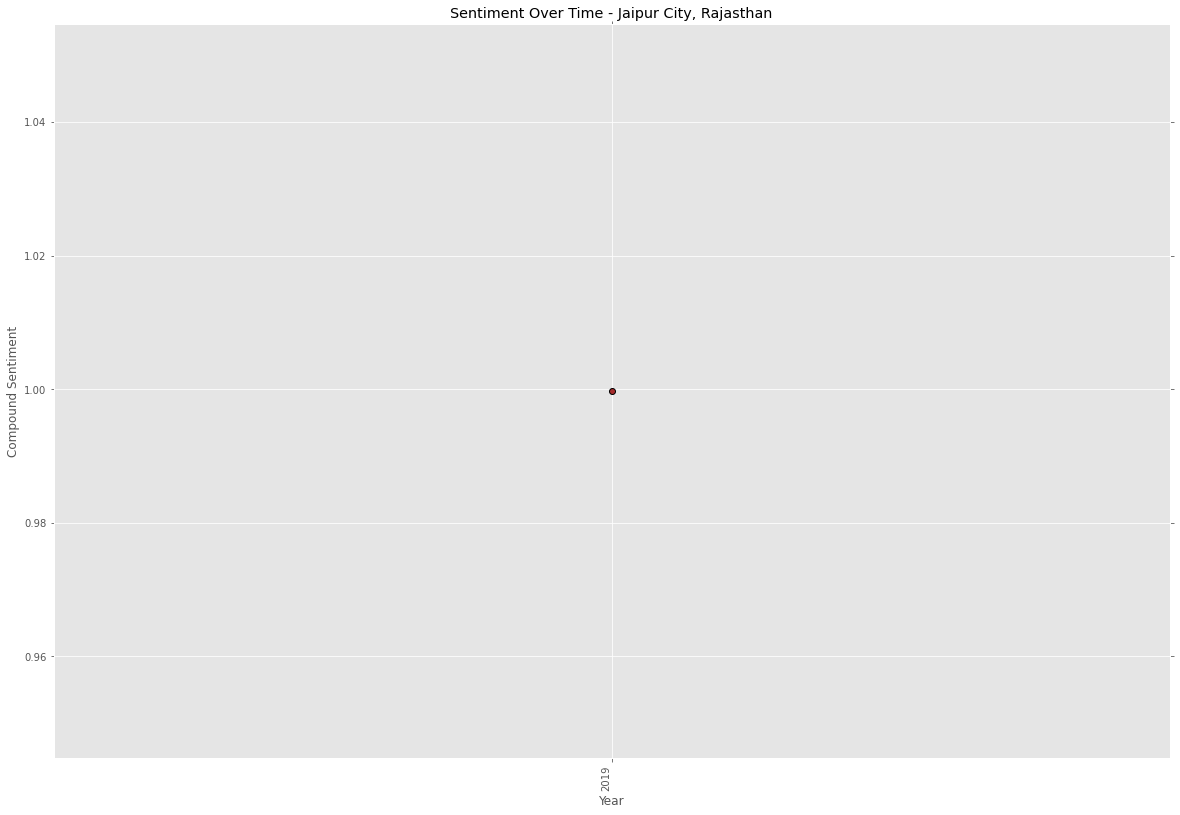

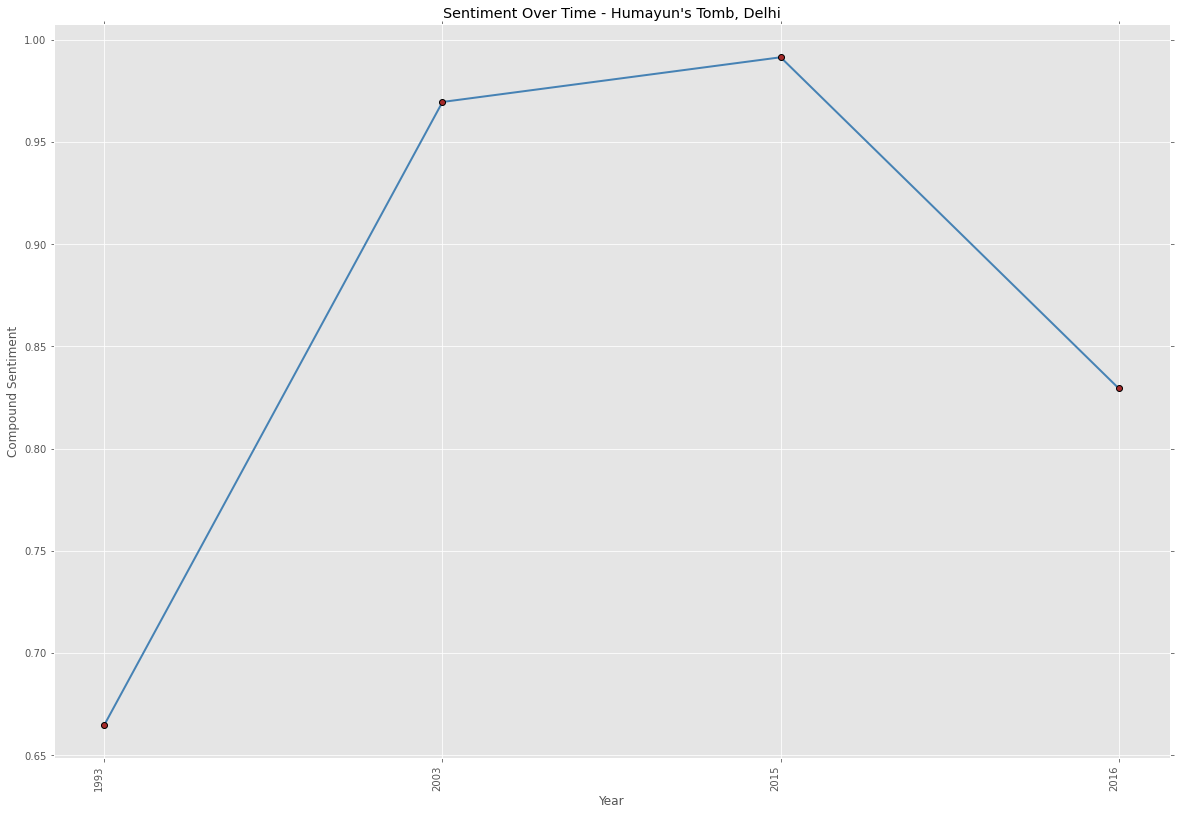

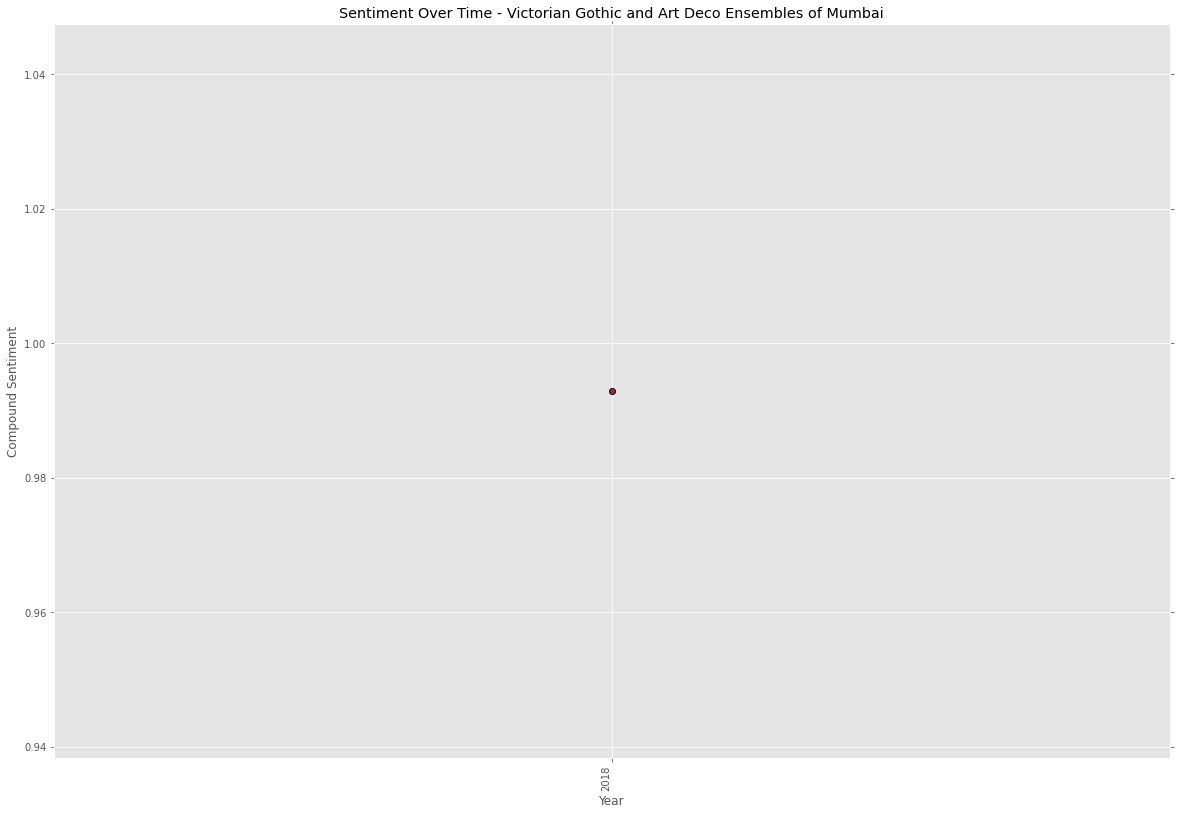

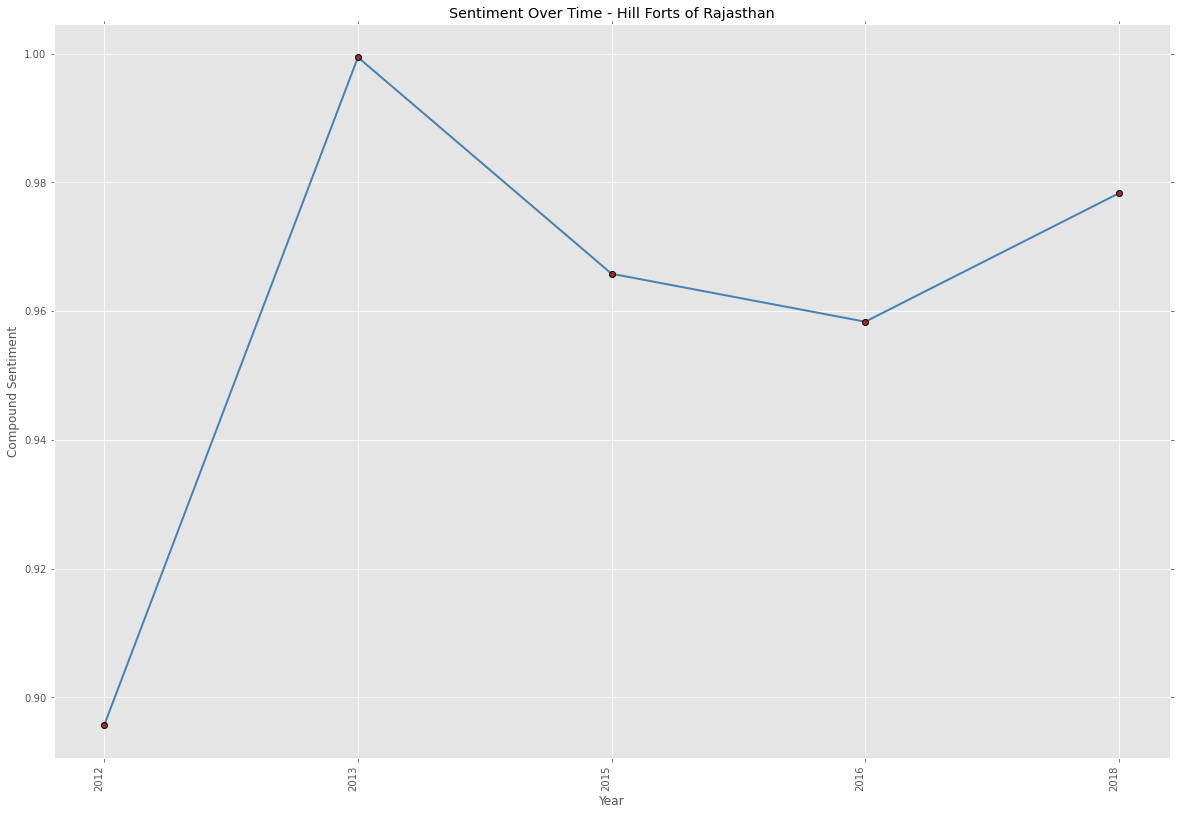

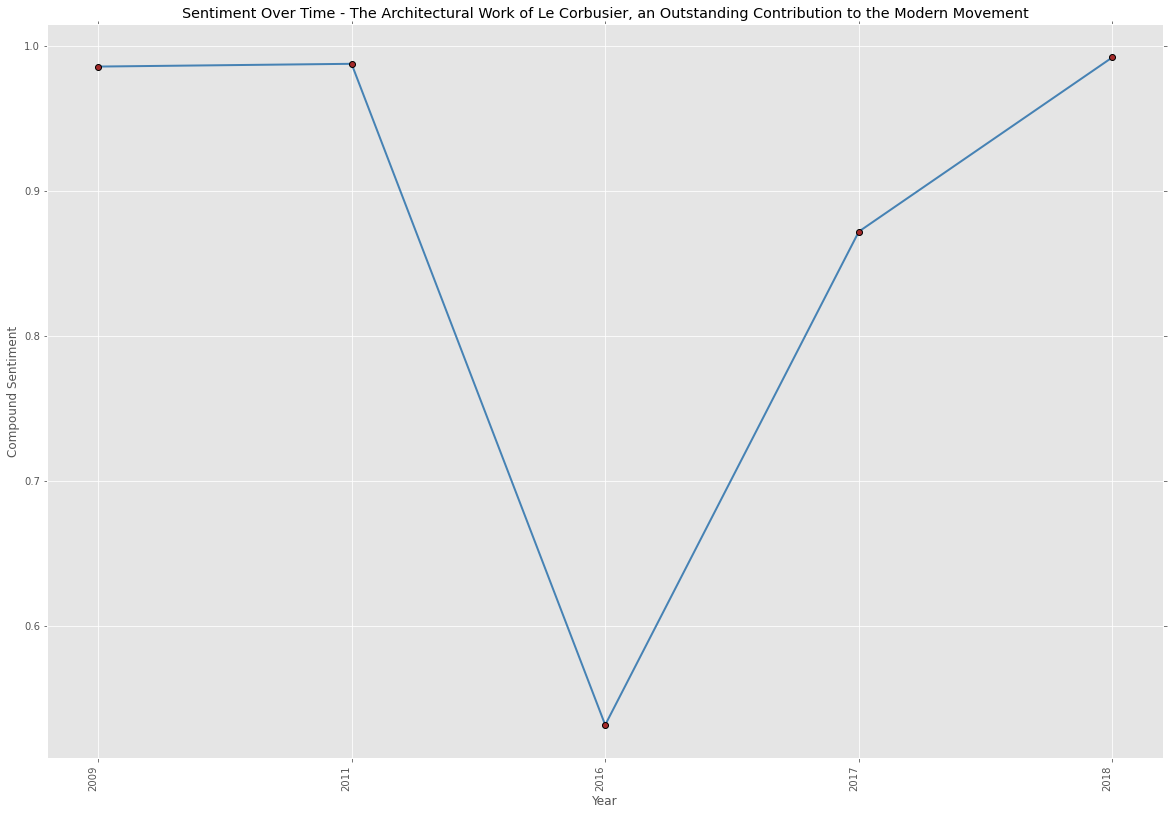

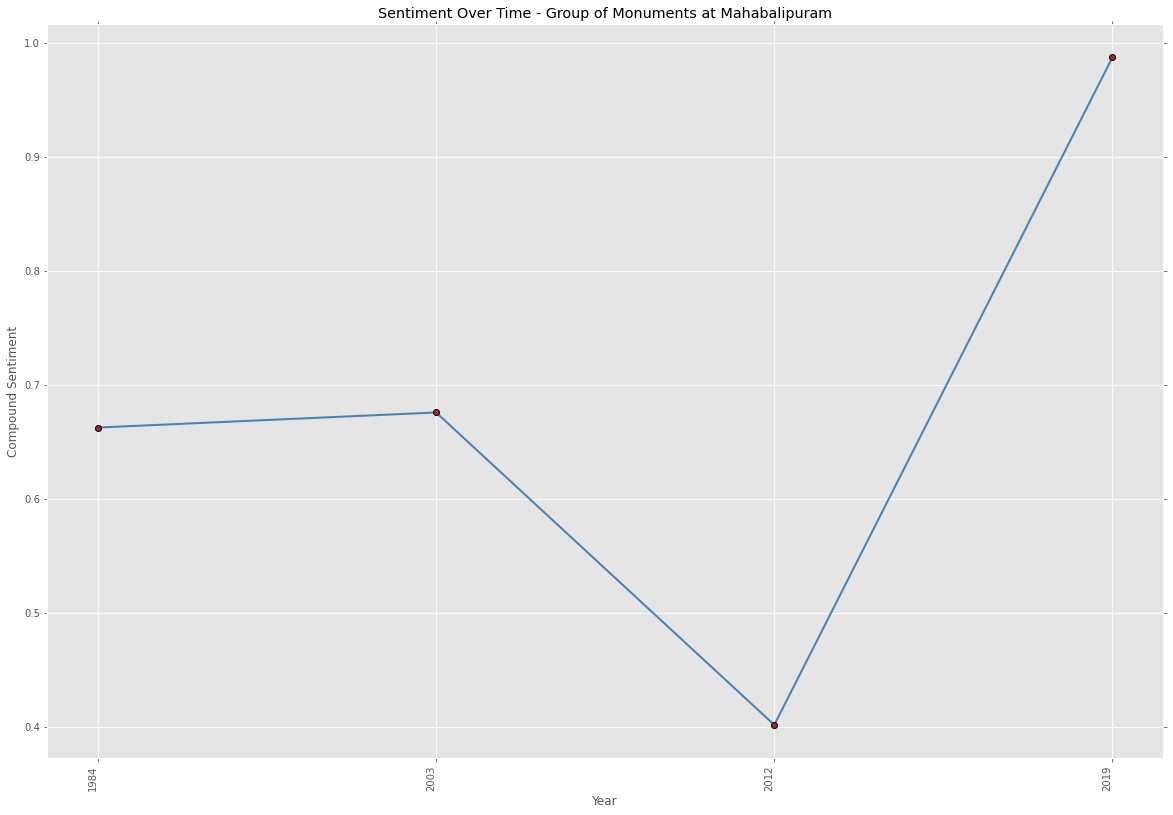

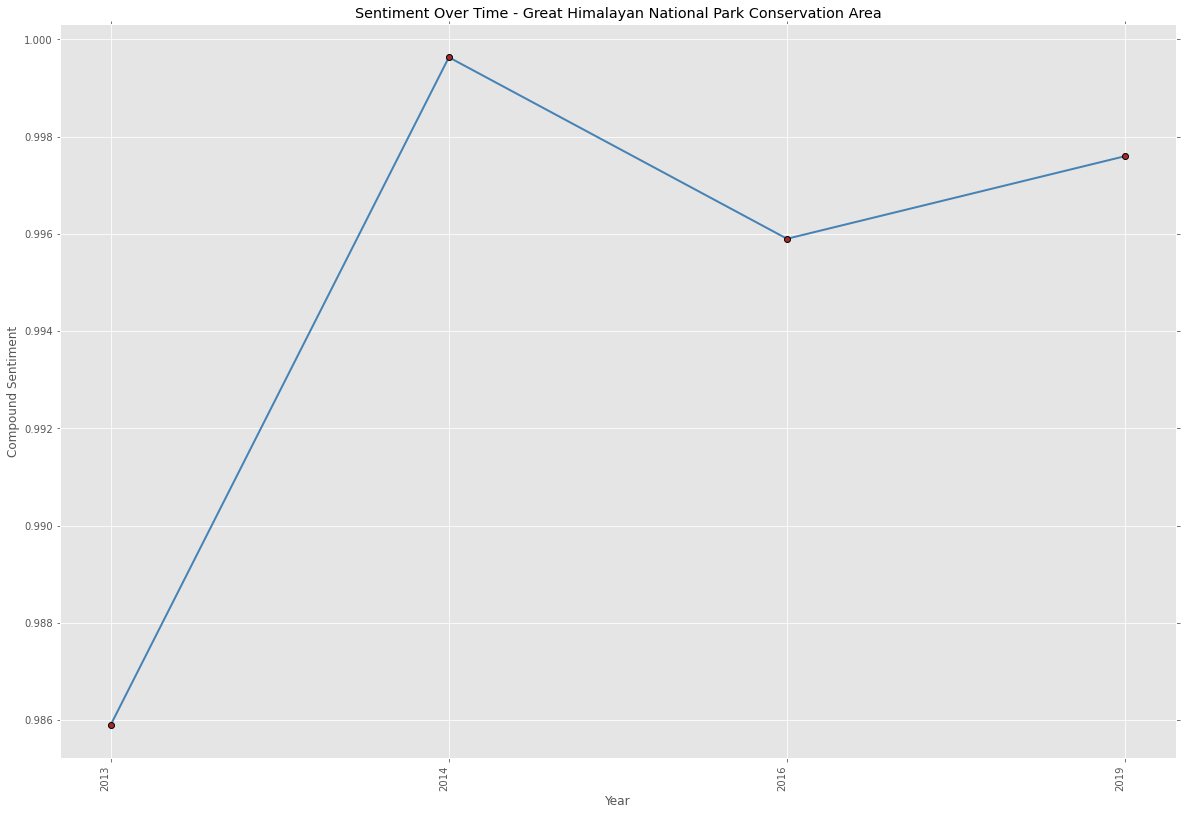

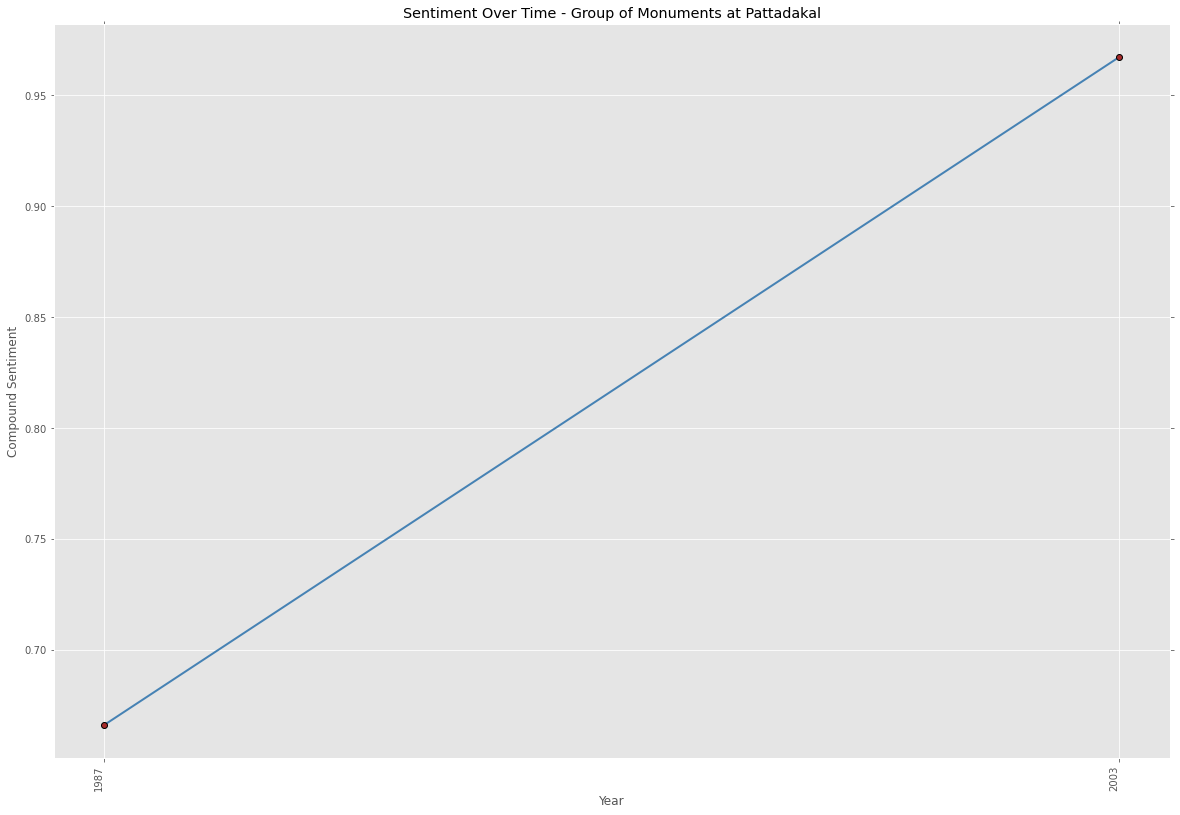

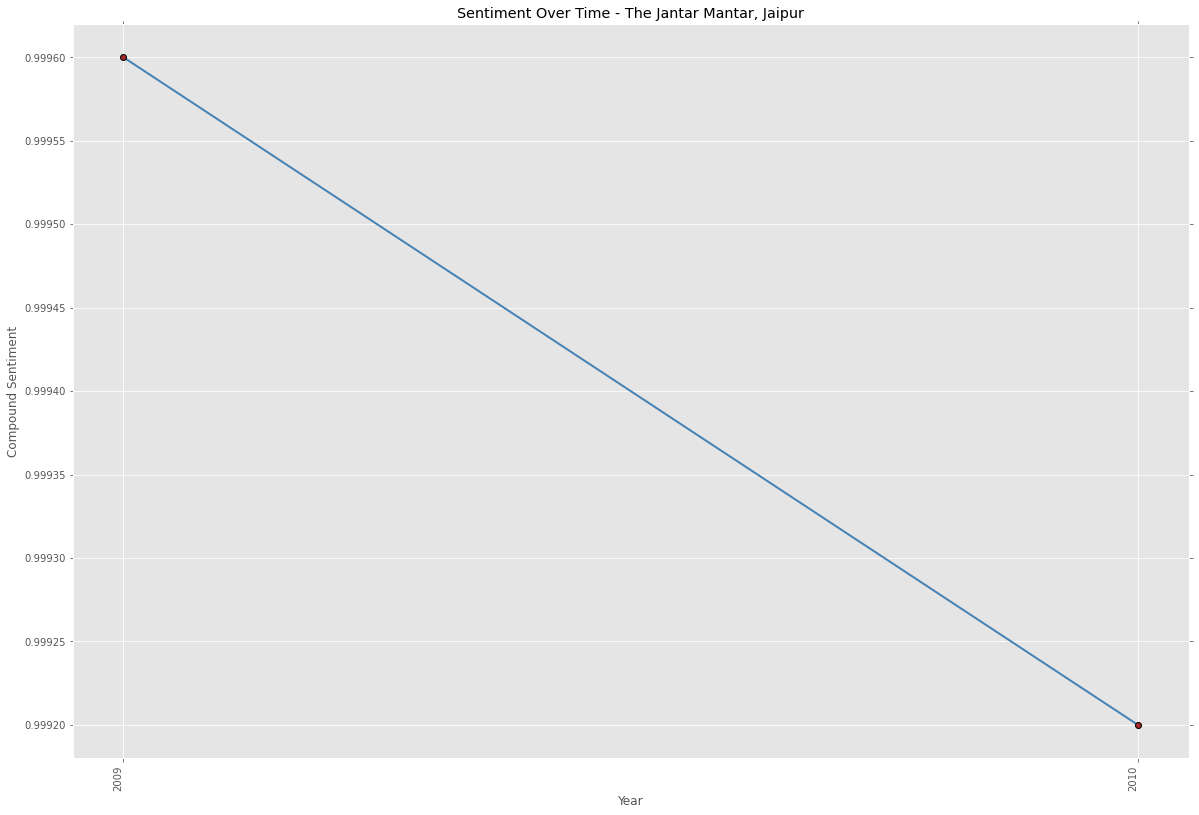

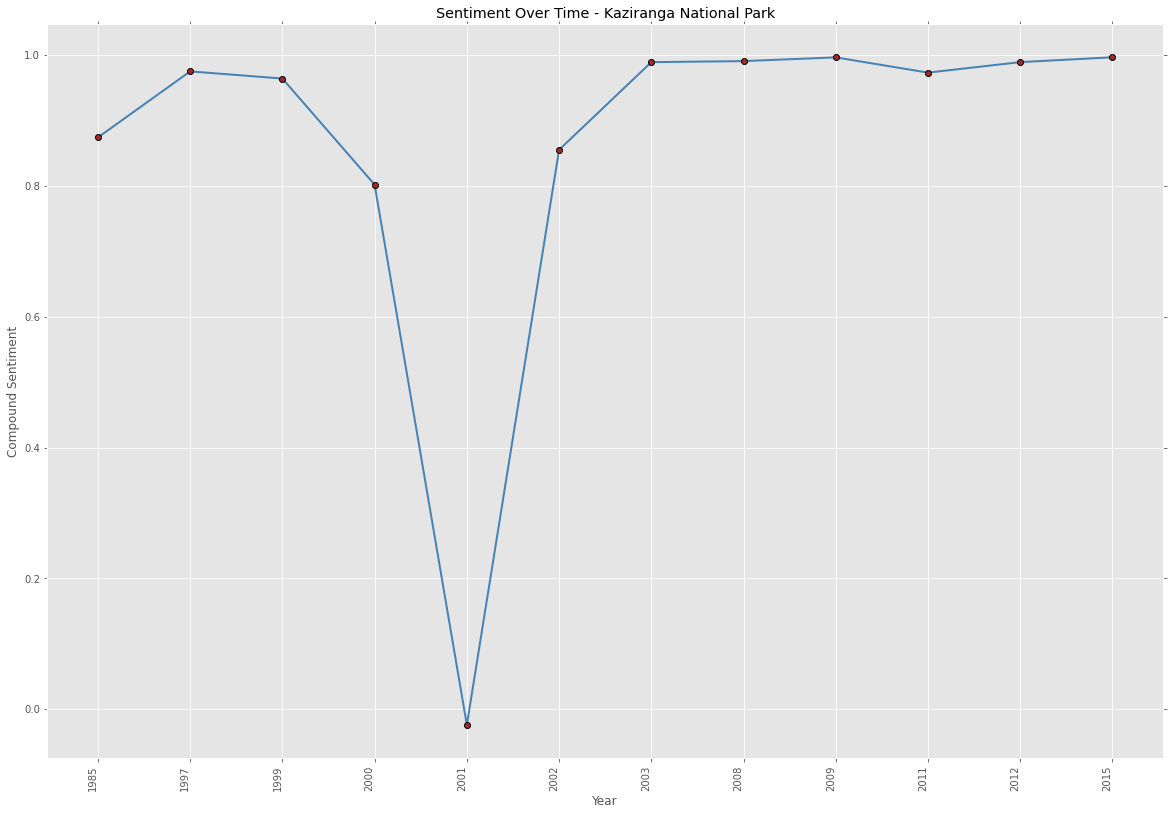

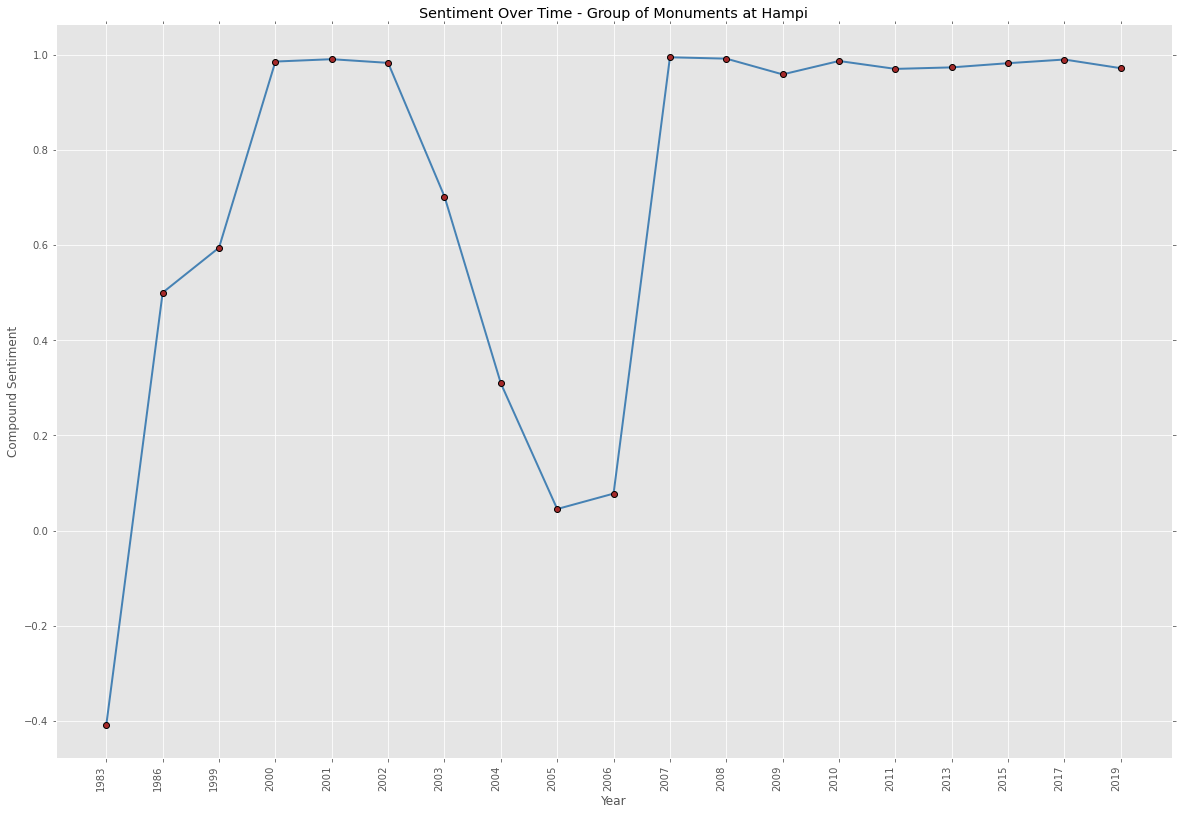

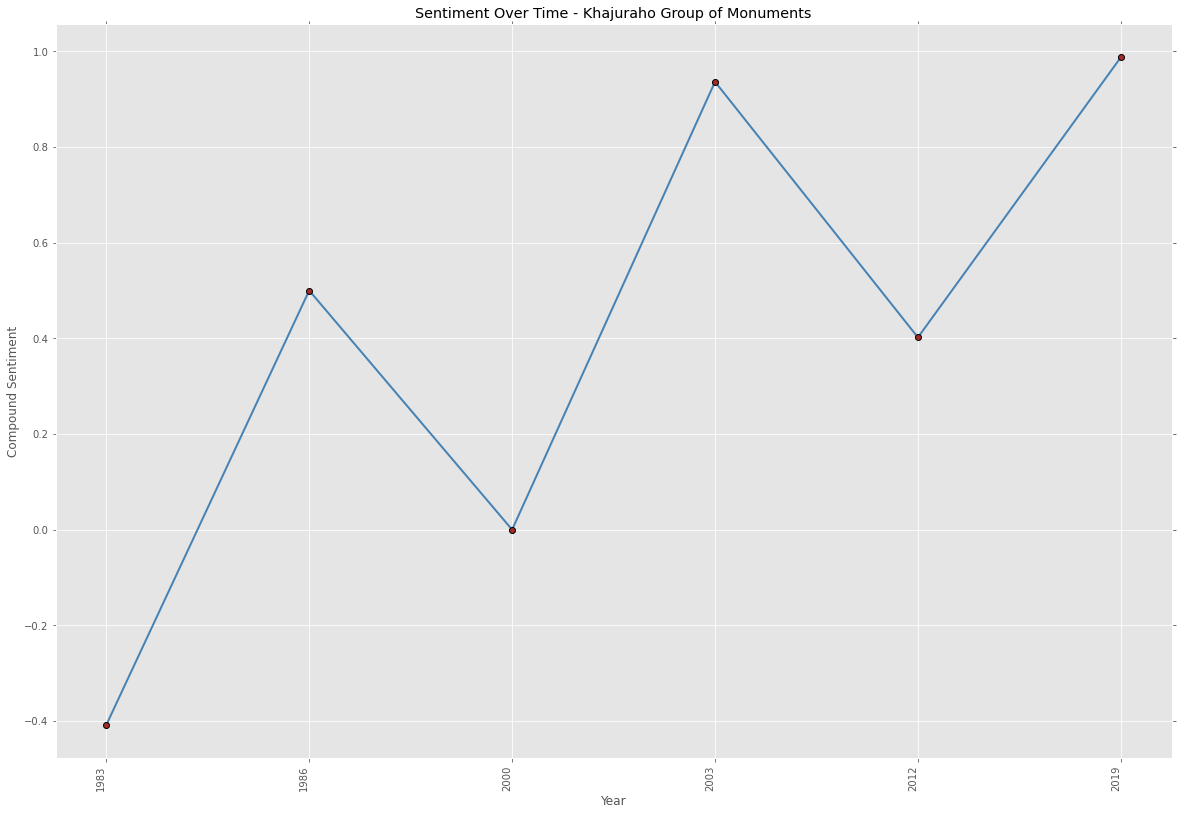

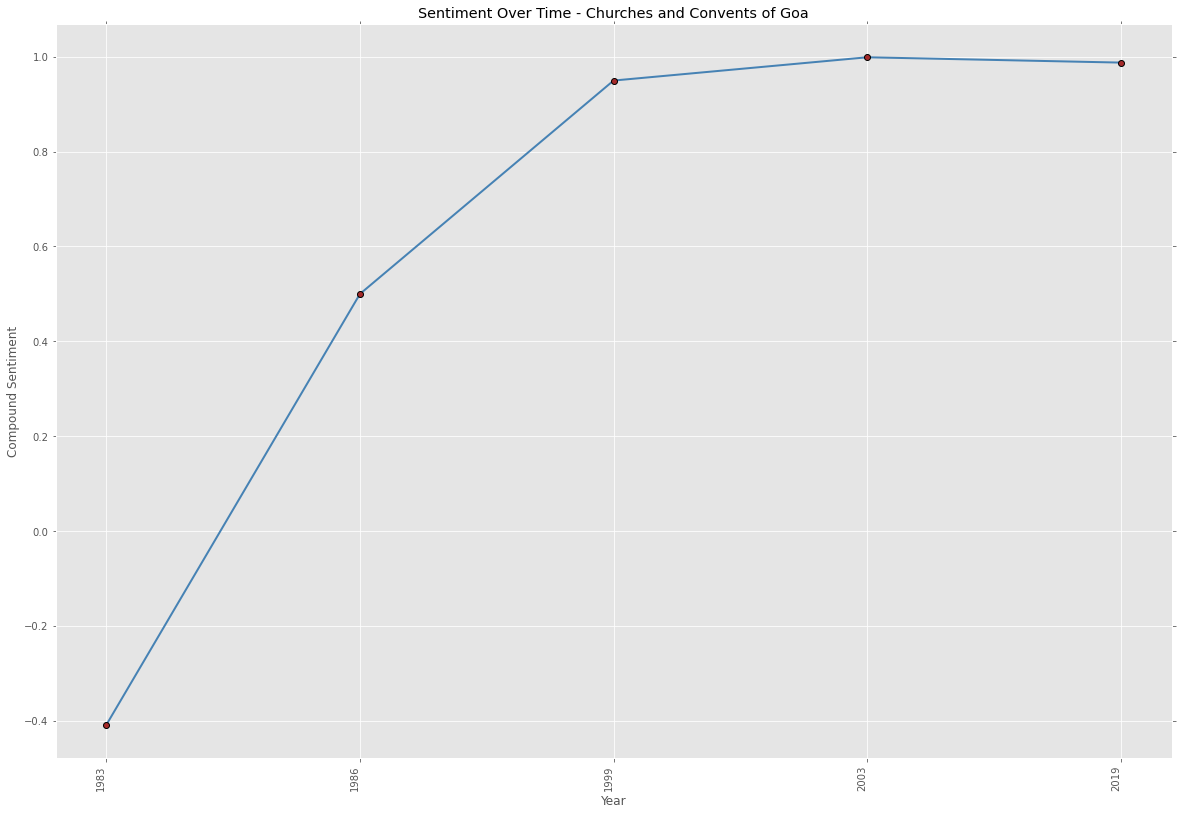

In [65]:
for i in range(0, len(data_india_for_analysis['site_name'].unique())):
    test = data_india_for_analysis[data_india_for_analysis['site_name'] == (data_india_for_analysis['site_name'].unique())[i]]
    test = test.reset_index(drop = True)
    if(len(test) >= 2):
        OvertimeAnalysis(test)

C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


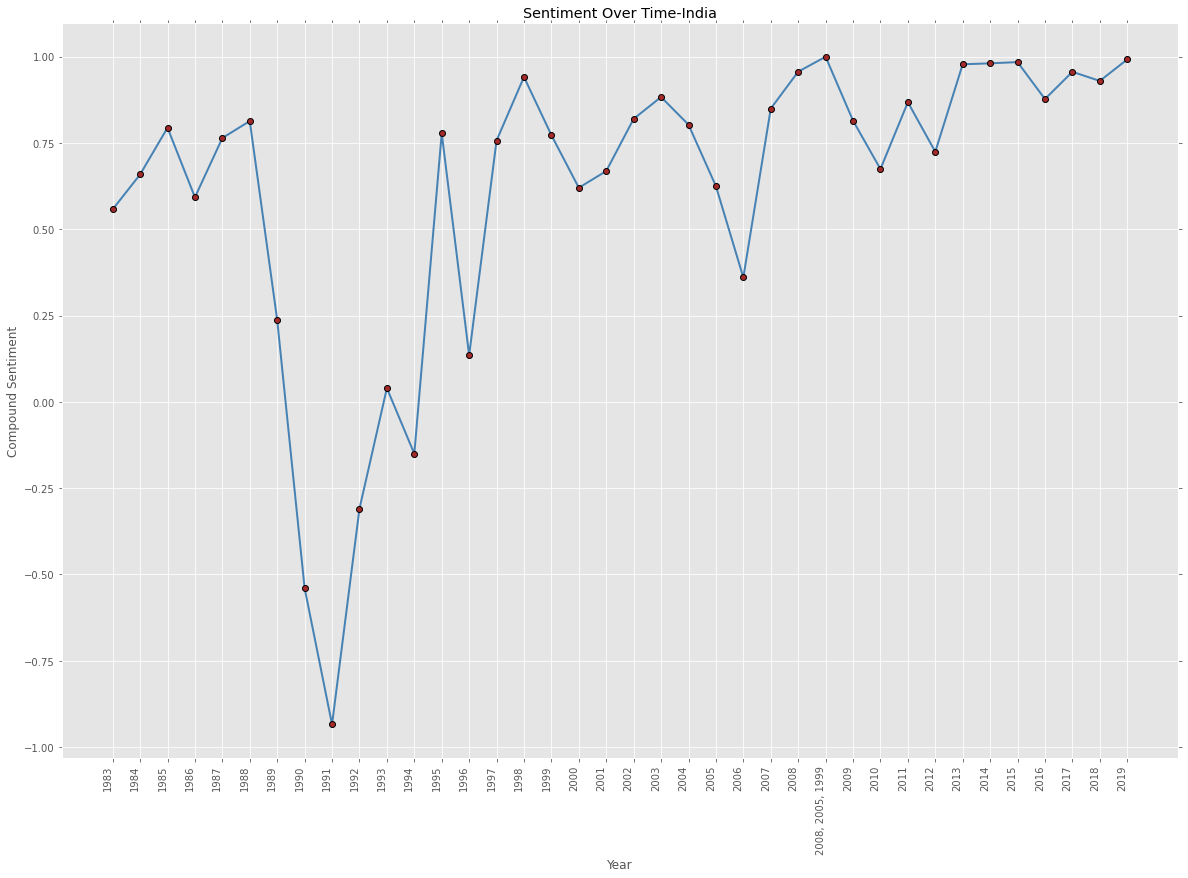

In [69]:
OvertimeAnalysis(data_india_for_analysis)

In [3]:
# data for Peru
data_for_peru = pd.read_excel('D:\\Peru Data.xlsx', sheet_name='Sheet1')
data_for_peru.head()

,country_name,country_link,site_name,site_link,coordinates,doc_title,doc_link,doc_year,doc_type,doc_content,...,Unnamed: 722,Unnamed: 723,Unnamed: 724,Unnamed: 725,Unnamed: 726,Unnamed: 727,Unnamed: 728,Unnamed: 729,Unnamed: 730,Unnamed: 731
0,Peru,https://whc.unesco.org/en/statesparties/pe,Chan Chan Archaeological Zone,https://whc.unesco.org/en/list/366,S8 6 28.21 W79 4 29.053,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/153276,1986,ABevaluation,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Peru,https://whc.unesco.org/en/statesparties/pe,City of Cuzco,https://whc.unesco.org/en/list/273,S13 31 2.194 W71 58 48.014,Advisory Body Evaluation (ICOMOS) / 脡valuation...,https://whc.unesco.org/document/153087,1983,ABevaluation,ICOM INTERNATIONAL COUNCIL CONSEIL 0S ON MONUM...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Peru,https://whc.unesco.org/en/statesparties/pe,Lines and Geoglyphs of Nasca and Palpa,https://whc.unesco.org/en/list/700,S14 43 32.988 W75 8 54.996,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/154050,1994,ABevaluation,WORLD HERITAGE LIST Nasca No 700 Identificatio...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Peru,https://whc.unesco.org/en/statesparties/pe,Historical Centre of the City of Arequipa,https://whc.unesco.org/en/list/1016,S16 23 54.071 W71 32 12.397,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/151538,2000,ABevaluation,Arequipa (Peru) No 1016 Identification Nominat...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Peru,https://whc.unesco.org/en/statesparties/pe,"Qhapaq 脩an, Andean Road System",https://whc.unesco.org/en/list/1459,S18 15 0 W69 35 30,Advisory Body Evaluation (ICOMOS),https://whc.unesco.org/document/152728,2014,ABevaluation,"Qhapagq Nan (Argentina, Bolivia, Chile, Colomb...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data_peru_for_analysis = data_for_peru.iloc[:, [2,5,7,9]]
data_peru_for_analysis.head(5)

,site_name,doc_title,doc_year,doc_content
0,Chan Chan Archaeological Zone,Advisory Body Evaluation (ICOMOS),1986,ICOMOS INTERNATIONAL COUNCIL ON MONUMENTS AND ...
1,City of Cuzco,Advisory Body Evaluation (ICOMOS) / 脡valuation...,1983,ICOM INTERNATIONAL COUNCIL CONSEIL 0S ON MONUM...
2,Lines and Geoglyphs of Nasca and Palpa,Advisory Body Evaluation (ICOMOS),1994,WORLD HERITAGE LIST Nasca No 700 Identificatio...
3,Historical Centre of the City of Arequipa,Advisory Body Evaluation (ICOMOS),2000,Arequipa (Peru) No 1016 Identification Nominat...
4,"Qhapaq 脩an, Andean Road System",Advisory Body Evaluation (ICOMOS),2014,"Qhapagq Nan (Argentina, Bolivia, Chile, Colomb..."


In [8]:
year = np.arange(1983, 2022, 1)
df_all = pd.DataFrame(year, columns=['doc_year'])

df_list = []

for i in range(0, len(data_peru_for_analysis['site_name'].unique())):
    test = data_peru_for_analysis[data_peru_for_analysis['site_name'] == (data_peru_for_analysis['site_name'].unique())[i]]
    test = test.reset_index(drop = True)
    if(len(test) >= 2):
        df_new = OvertimeAnalysis_doc(test)
    df_1 = pd.merge(df_all, df_new, on = 'doc_year', how = 'right')
    df_list.append(df_1)

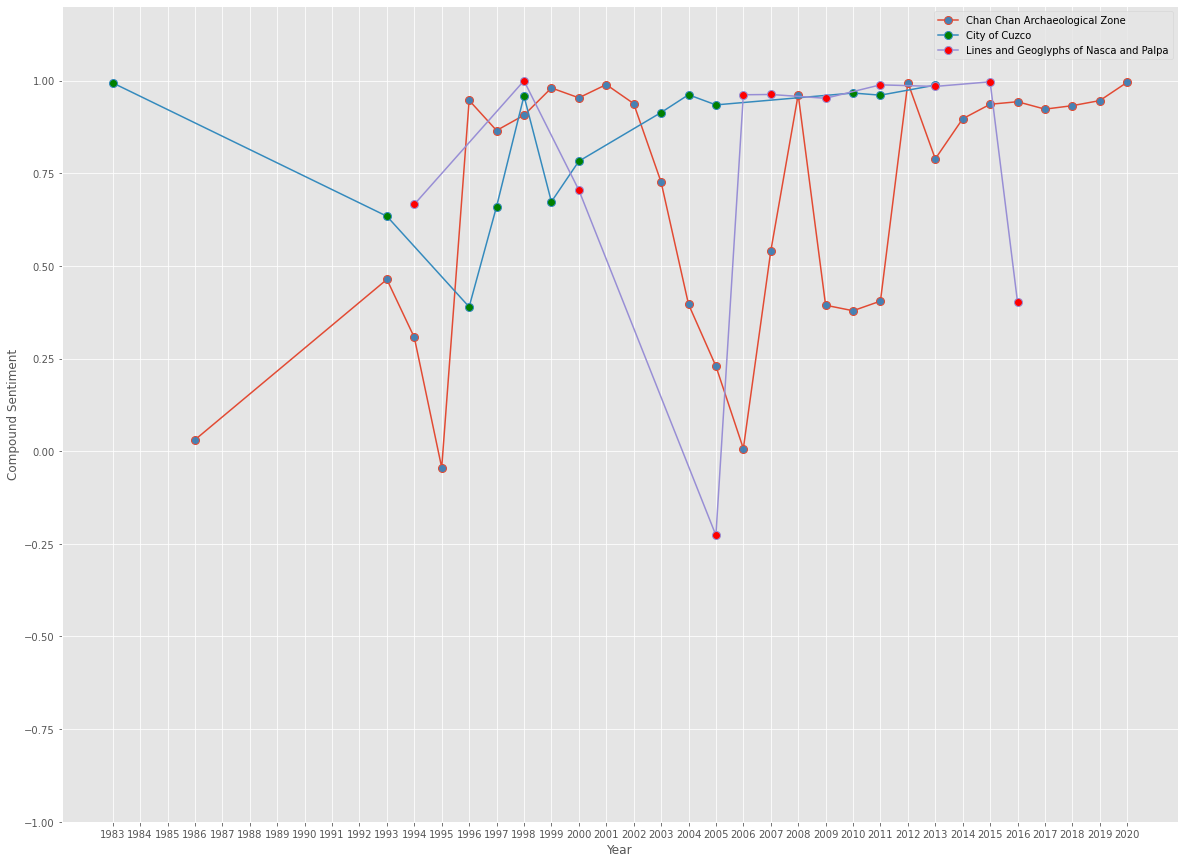

In [9]:
plt.style.use('ggplot')

fig = plt.figure(figsize=(20, 15))

plt.plot(df_list[0]['doc_year'],df_list[0]['sentiment'], marker = 'o', markersize = 8, markerfacecolor = 'steelblue', label = 'Chan Chan Archaeological Zone')
plt.plot(df_list[1]['doc_year'],df_list[1]['sentiment'], marker = 'o', markersize = 8, markerfacecolor = 'green', label = 'City of Cuzco')
plt.plot(df_list[2]['doc_year'],df_list[2]['sentiment'], marker = 'o', markersize = 8, markerfacecolor = 'red', label = 'Lines and Geoglyphs of Nasca and Palpa')

plt.xticks(range(1983, 2021 ,1))
plt.ylim(-1, 1.2)
plt.xlabel('Year')
plt.ylabel('Compound Sentiment')
plt.legend()
plt.savefig('part1_Peru.svg', format = 'svg')
plt.show()

C:\Users\86138\AppData\Roaming\Python\Python36\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


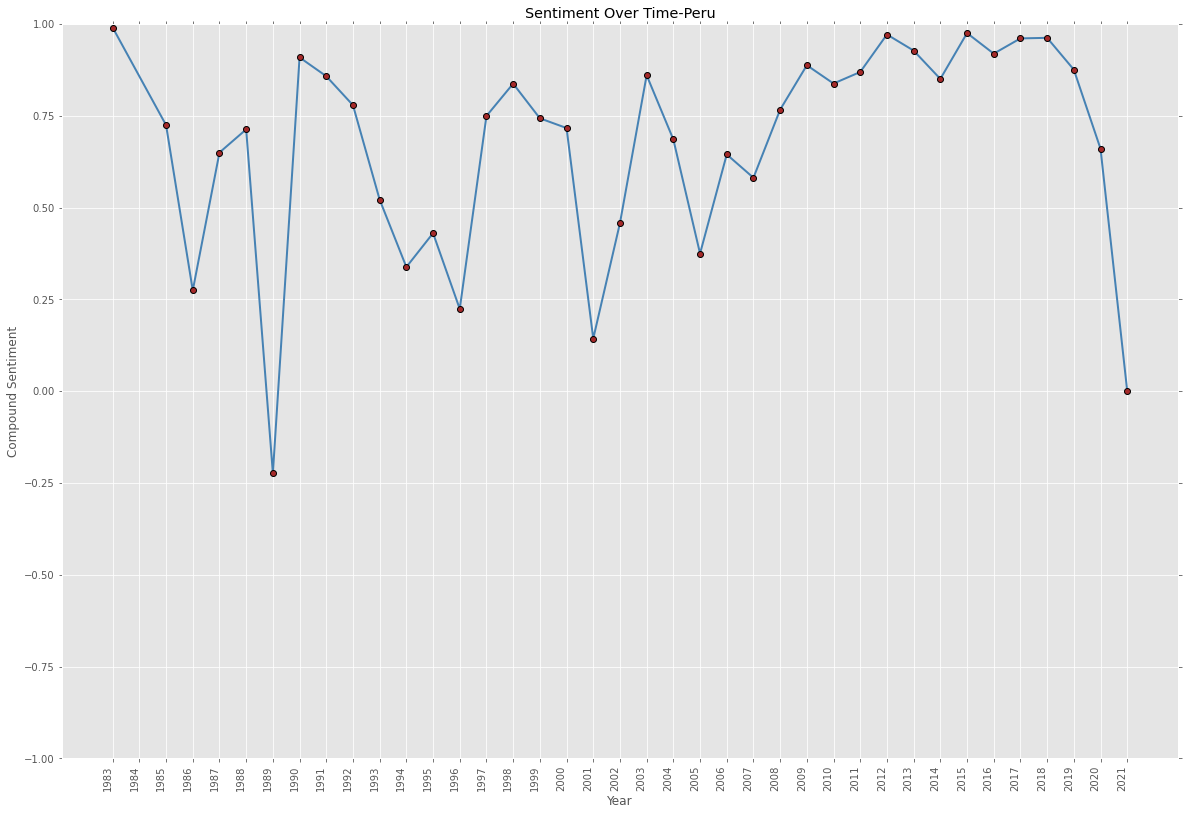

In [13]:
OvertimeAnalysis(data_peru_for_analysis)